# «Модель прогнозирования стоимости жилья для агентства недвижимости»

### ПОСТАНОВКА ЗАДАЧИ

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Типовая задача из области Data Science, основанная на данных о недвижимости в США.

**Бизнес-задача:** улучшить финансовые показатели компании за счет уменьшения времени на обработку информации о недвижимости у риелторов.

**Техническая задача для вас как для специалиста в Data Science:** разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

Итак, была произведена обработка и очистка данных. Далее этап EDA.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, kruskal
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce

In [2]:
#прочитаем данные из файла
r = pd.read_csv('clean_data.csv', sep = ',') 

In [3]:
#проверим, что данные выгрузились корректно, для этого выведем первые две строки датафрейма
display('Очищенная таблица данных недвижимости',r.head())

'Очищенная таблица данных недвижимости'

status  baths            city    sqft  zipcode  beds state  heating  \
0  active    3.5  southern pines  2900.0  28387.0   4.0    NC        1   
1  active    3.0  spokane valley  1947.0  99216.0   3.0    WA        0   
2  active    2.0     los angeles  3000.0  90049.0   3.0    CA        1   
3  active    8.0          dallas  6457.0  75205.0   5.0    TX        1   
4  active    0.0    philadelphia   897.0  19145.0   2.0    PA        1   

   cooling  sch_rating  sch_dist       type     target  last_year  
0        0         5.0       5.5   single_1   418000.0       2019  
1        0         4.0       1.5   single_2   310000.0       2019  
2        1         6.0       1.6   single_1  2895000.0       1967  
3        1         9.0       0.7   single_3  2395000.0       2006  
4        1         0.0       0.0  townhouse   209000.0       1920

Помним, что наша таблица содержит пропуски, которые заполнены 0. Создадим несколько новых признаков и потом вернемся к их обработке.

### Создадим признак climate_system

Он будет отражать наличие или отсутствие системы, поддерживающей необходимую температуру, т.е. его значения будут находиться на пересечении значений признаков heating и cooling равных 1 (т.е. заполненных данных)

In [4]:
def climate_system(x,y):
    '''Функция принимает два аргумента.
    
       Функция возвращает 1, если оба аргумента равны единицы, возвращает 0, если оба аргумента равны 0.
    '''
    if (x==1) and (y==1):#если x равно 1 и y равно 1
        return 1 #возвращаем 1
    else:#иначе
        return 0 #возвращаем 0

In [5]:
# применим нашу формулу для построения признака к столбцам cooling и heating
r['climate_system']=r[['heating','cooling']].apply(lambda x: climate_system(*x), axis=1)
# удалим столбцы из таблицы
r.drop(['heating','cooling'], axis=1, inplace=True)

### Создадим признак property_age

Он будет отражать возраст недвижимости, получим его вычетом признака last_year из 2023 года.

In [6]:
#создадим признак property_age
r['property_age']=r['last_year'].map(lambda x: int(2023 - x) if x!=0 else 0)
#удалим признак last_year
r.drop('last_year', axis=1, inplace=True)

### Создадим признак capital_state

Он будет отражать является ли город столицей штата или нет: 1 - столица штата, 0 - не столица.

In [7]:
#создадим словарь штатов и столиц
state_capital = {'AL':'Montgomery','AK':'Juneau','AZ':'Phoenix','AR':'rock little','CA':'sacramento',
                 'CO':'denver','CT':'hartford','DE':'dover','FL':'Tallahassee','GA':'Atlanta',
                 'ID':'Boise','IL':'Springfield','IN':'Indianapolis','IA':'Des Moines','KS':'Topeka',
                 'KY':'Frankfort','LA':'Baton Rouge','ME':'Augusta','MD':'Annapolis','MA':'Boston',
                 'MI':'Lansing','MN':'Saint Paul','MS':'Jackson','MO':'Jefferson','MT':'Helena',
                 'NE':'Lincoln','NV':'Carson','NH':'Concord','NJ':'Trenton', 'NM':'Santa Fe','NY':'Albany',
                 'NC':'Raleigh','ND':'Bismarck','OH':'Columbus','OK':'Oklahoma','OR':'Salem', 
                 'PA':'Harrisburg', 'RI':'Providence','SC':'Columbia','SD':'Pierre','TN':'Nashville',
                 'TX':'Austin','UT':'Salt Lake', 'VT':'Montpelier','VA':'Richmond','WA':'Olympia',
                 'WV':'Charleston','WI':'Madison','WY':'Cheyenne','HI':'Honolulu','DC':'Washington'}

In [8]:
#напишем функцию, которая поможет создать признак capital_state
def get_capital(c,s):
    '''Функция на вход получает два значения, которые представляют собой строки.
       
       Функция возвращает 1, если город соответствует столице штата, 0, если не соответствует
    '''
    #если значение с равно значению из словаря, соответствующему ключу словаря s
    if (state_capital.get(s).lower())==c:
        result= 1 #то присваиваем result значение 1
    else: #иначе, если значение отлично от значения из словаря
        result= 0 #то присваиваем result значение 0
    return result #возвращаем result

In [9]:
#создадим с помощью функции get_capital признак capital_state
r['capital_state']=r[['city','state']].apply(lambda x: get_capital(*x), axis=1)

In [10]:
r1=r.copy()

Перейдем к обработке пропусков.

In [11]:
#вернем нулевым значениям значения nan
num_feature = ['baths','sqft','beds','sch_rating','sch_dist','property_age']
r1[num_feature]=r1[num_feature].replace(0,np.nan)

In [12]:
#проверим пропуски в таблице
#r1.isnull().sum()

In [13]:
#посмотрим на число неинформативных строк, которые содержат меньше 70 % пропущенных значений
len_r = r.shape[0]
#удаляем неинформативные наблюдения
trash = r1.shape[1]*0.7#определяем число непустых значений в строке
#удаляем строки, содержащией меньше 70 % непустых знаячений
r1 = r1.dropna(thresh = trash, axis=0)
display('Число удаленных записей {0}'.format(len_r-r.shape[0]))

'Число удаленных записей 0'

Заполним пропущенные значения в признаках медианными значениями, так как медиана не чувствительна к выбросам:
- для baths, sqft, beds, property_age - по типу недвижимости;
- для sch_dist, sch_rating - по zipcode.

Для заполнения будем использовать функцию написанную на этапе очистки данных fill_null.

Единственный пропуск в zipcode, который возник при переносе данных, удалим.

In [14]:
#определим индекс пустого значения признака zipcode в таблице
zipcode_null=r1[r1['zipcode'].isnull()==True].index
#удалим пропущенное значение в признаке zipcode
r1.drop(zipcode_null, axis=0, inplace=True)

In [15]:
#функция для заполнения пустых значений медианным значением по типу недвижимости
def fill_null(df,f1,f2,lst):
    '''Функция принимает на вход:
    - df - датафрейм, 
    - f1 - признак, который необходимо обработать,
    - f2 - признак, по которому происходит группировка для поиска медианы,
    - lst - список групп
    
    Функция возвращает обработанный столбец признака f1
    '''
    for i in lst: #проходимся в цикле по всем типу недвижимости, по которым находим медиану
        df_f2 = df[df[f2]==i][f1] #фильтруем df по признаку f2 и выводим значения f1
        null_ind = df_f2[df_f2.isnull()==True].index #находим индексы для пустых значений признака f1
        if len(df[df[f2]==i][f2])==len(df_f2[df_f2.isnull()==True].index):
            df.loc[null_ind,f1] = df[f1].median()          
        else:
            df.loc[null_ind,f1] = df[df[f2]==i][f1].median() #заполняем пустые значения признака f1 медианой         
    return df[f1]

In [16]:
#зададим список типов недвижимости для расчета медианы
type_list = ['single_1', 'single_2','single_3','single_4','condo', 'townhouse', 'multi', 'apartment','mobile',
             'other','cabin','not_land']

In [17]:
#заполним пропуски медианными значениями 
r1['baths'] = fill_null(r1,'baths','type',type_list)
r1['beds'] = fill_null(r1,'beds','type',type_list)
r1['sqft'] = fill_null(r1,'sqft','type',type_list)
r1['property_age'] = fill_null(r1,'property_age','type',type_list)

#проверяем, есть ли пустые значения
display('Число пустых значений в признаке baths равно {0}.'.format(r1['baths'].isnull().sum()))
display('Число пустых значений в признаке beds равно {0}.'.format(r1['beds'].isnull().sum()))
display('Число пустых значений в признаке sqft равно {0}.'.format(r1['sqft'].isnull().sum()))
display('Число пустых значений в признаке property_age равно {0}.'.format(r1['property_age'].isnull().sum()))

'Число пустых значений в признаке baths равно 0.'

'Число пустых значений в признаке beds равно 0.'

'Число пустых значений в признаке sqft равно 0.'

'Число пустых значений в признаке property_age равно 0.'

In [18]:
#выделим в отдельную таблицу наблюдения, содержащие нулевые значения признака рейтинга школ
rating_null = r1[r1['sch_rating'].isnull()==True]
#определим список значений zipcode, по которым будем искать медиану
zip_list = r1.groupby(['zipcode'])['sch_rating'].median().index

#заполним пропуски в признаке sch_rating медианными значениями, группируя по zipcode
r1['sch_rating'] = fill_null(r1,'sch_rating','zipcode',zip_list)

display('Число пропусков в признаке sch_rating: {:.3f} %'.format(r1['sch_rating'].isnull().mean()*100))

'Число пропусков в признаке sch_rating: 0.000 %'

In [19]:
#выделим в отдельную таблицу наблюдения, содержащие нулевые значения признака рейтинга школ
dist_null = r1[r1['sch_dist'].isnull()==True]
#определим список значений zipcode, по которым будем искать медиану
zip_dist_list = r1.groupby(['zipcode'])['sch_dist'].median().index

#заполним пропуски в признаке sch_rating медианными значениями, группируя по zipcode
r1['sch_dist'] = fill_null(r1,'sch_dist','zipcode',zip_dist_list)

display('Число пропусков в признаке sch_dist: {:.3f} %'.format(r1['sch_dist'].isnull().mean()*100))

'Число пропусков в признаке sch_dist: 0.000 %'

In [20]:
#категориальные признаки status, type, state
cat_feature = ['status','type','state','city','zipcode']
#бинарные признаки
bin_feature = ['climate_system','capital_state']
#числовые признаки
num_feature = ['baths','sqft','beds','sch_rating','sch_dist','property_age']

Посмотрим на описательные статистики числовых признаков.

In [21]:
r1[num_feature].describe()

baths           sqft           beds     sch_rating  \
count  333070.000000  333070.000000  333070.000000  333070.000000   
mean        2.644863    2594.162922       3.302408       5.029425   
std         1.299058   10076.170734       1.489056       2.178335   
min         0.500000       1.000000       1.000000       1.000000   
25%         2.000000    1305.000000       3.000000       3.000000   
50%         2.000000    1816.000000       3.000000       5.000000   
75%         3.000000    2601.000000       4.000000       7.000000   
max        76.000000  914921.000000      99.000000      10.000000   

            sch_dist   property_age  
count  333070.000000  333070.000000  
mean        2.784576      38.735500  
std         6.103431      30.519995  
min         0.020000       1.000000  
25%         1.000000      16.000000  
50%         1.700000      33.000000  
75%         3.200000      57.000000  
max      1590.700000     815.000000

Очевидно, что в данных есть выбросы, об этом можно судить по 75 % квартилю и максимальному значению в признаке. Также можно предположить, что распредления признаков отличны от нормального, имеется смещение распределения, так как медиана в некоторых признаках сильно отличается от среднего значения.

Посмотрим на распределение признаков и на возможные выбросы.

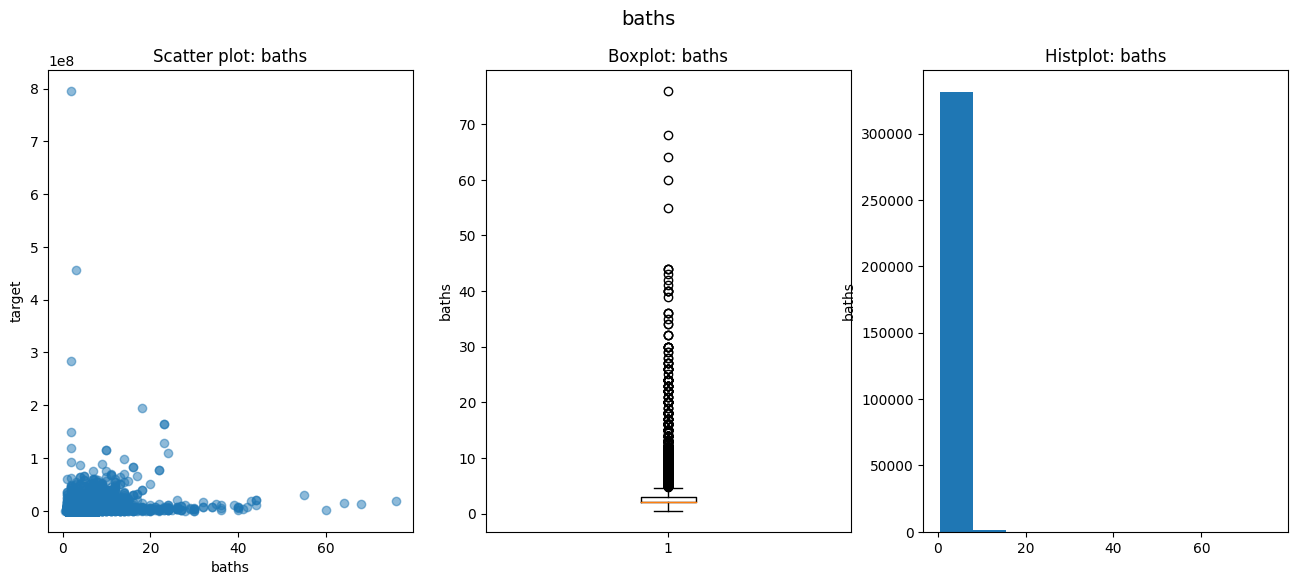

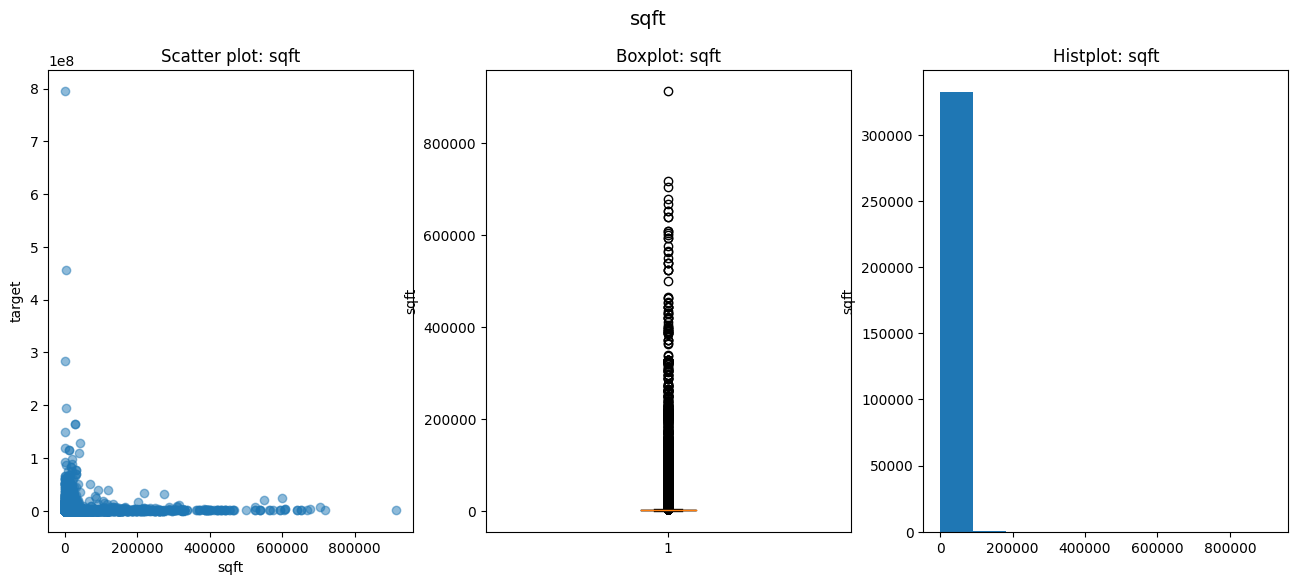

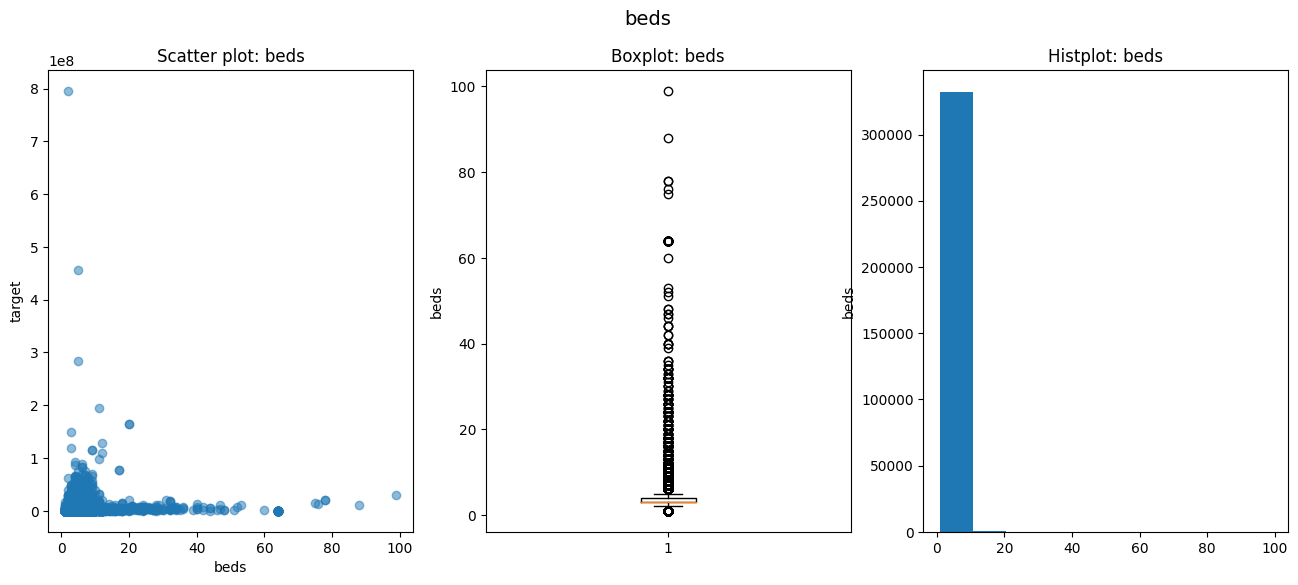

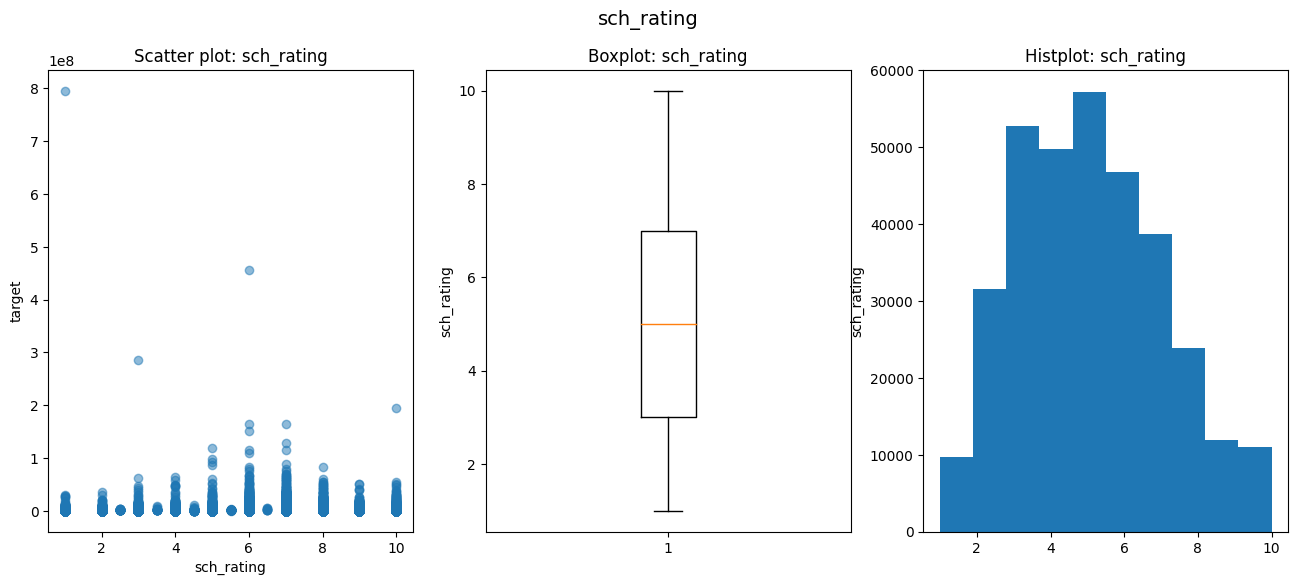

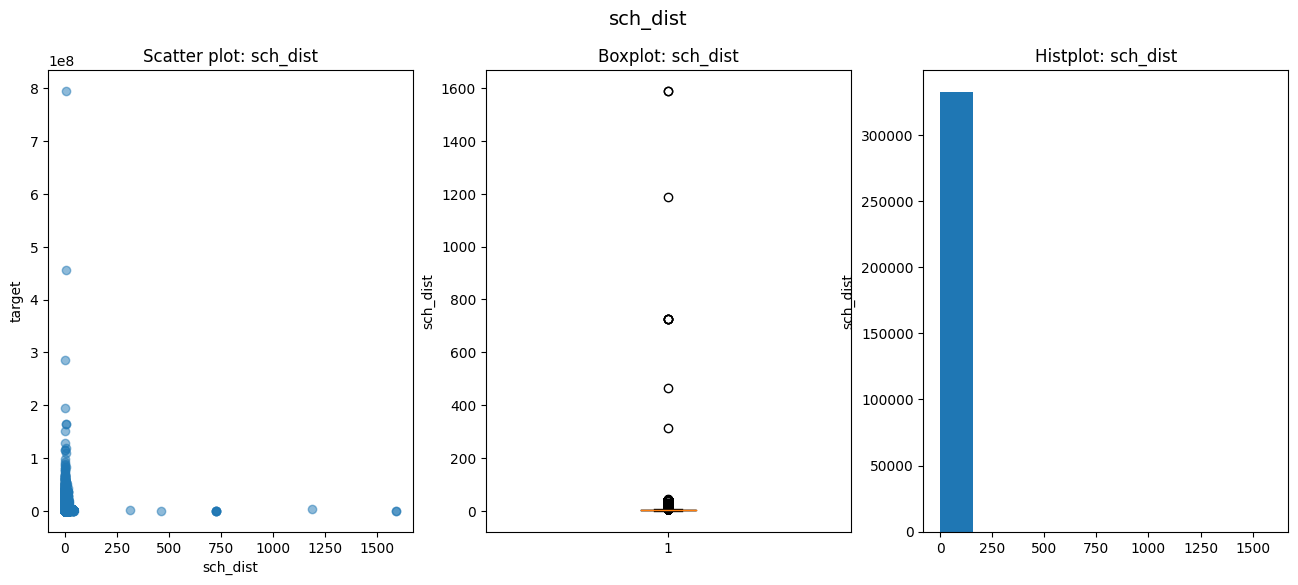

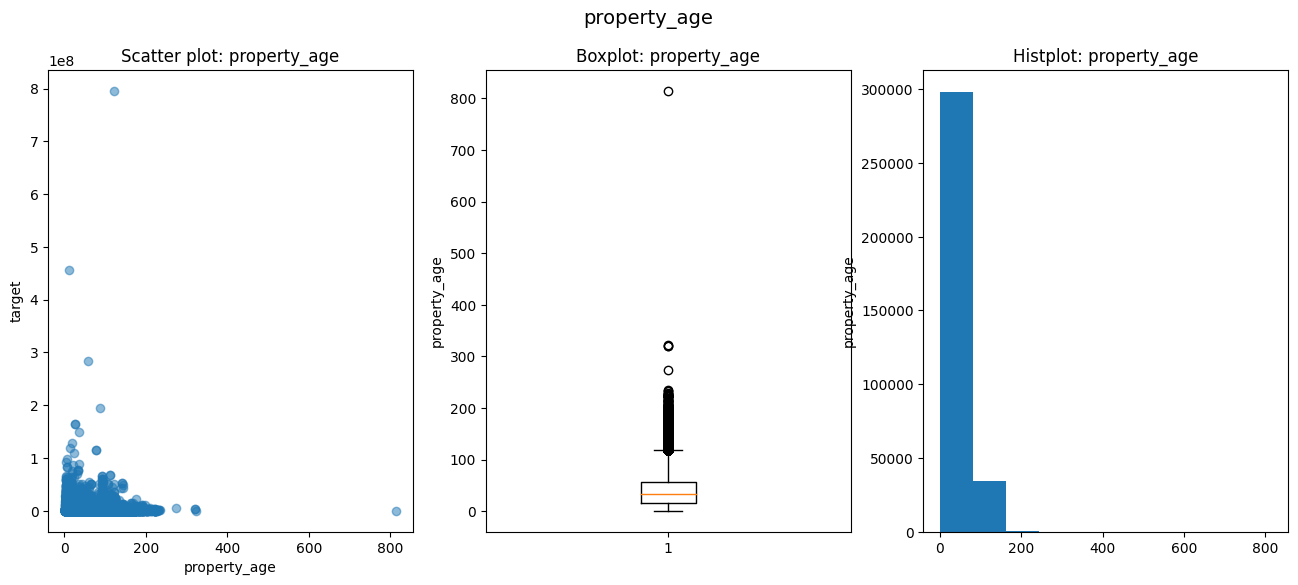

In [22]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r1[feature], r1['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r1[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r1[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

Судя, по графикам, подтвердилось предположение о том, что почти во всех признаках есть выбросы, а распределение признаков далеко от нормального. Исключением является признак sch_rating. Для поиска выбросов будем использовать метод z-отклонений с логарифмирование. Воспользуемся формулой, написанной в курсе.

In [23]:
r2=r1.copy()

In [24]:
def outliers_z_score(data, feature, log_scale=False,left=3,right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [25]:
# найдем выбросы в признаке baths
outliers_bh, cleaned_bh = outliers_z_score(r2, 'baths', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_bh.shape[0]}')
print(f'Результирующее число записей: {cleaned_bh.shape[0]}')

Число выбросов по методу z-отклонения: 2839
Результирующее число записей: 330231


In [26]:
#посмотрим на значения признака, которые попали в выбросы
np.sort(outliers_bh['baths'].unique())

array([ 0.5,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ,
       12.5, 13. , 14. , 14.5, 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       22. , 23. , 24. , 25. , 26. , 27. , 28. , 29. , 30. , 32. , 34. ,
       35. , 36. , 39. , 40. , 41. , 42. , 43. , 44. , 55. , 60. , 64. ,
       68. , 76. ])

In [27]:
display('Число выбросов в признаке bath по отношению к общему числу наблюдений равно:{:.3f} %'\
    .format(outliers_bh.shape[0]/r2.shape[0]*100))

'Число выбросов в признаке bath по отношению к общему числу наблюдений равно:0.852 %'

В наблюдениях, которые попали в число выбросов, большая часть (2223 наблюдения) содержит информацию, в которой число ванных комнат превышает намного число спален, к тому же эти наблюдения имеют сравнительно маленькую площадь для большого числа ванных комнат.

В остальных 349 наблюдениях, тоже встречаются наблюдения с большим числом ванных комнат и небольшой площадью недвижимости.

Число наблюдений относящихся к выбросам меньше процента, удалим их из таблицы.

In [28]:
#сохраним в нашу таблицу таблицу с очищенными значениями
r2=cleaned_bh.copy()

Снова отрисуем графики и посмотрим, как они изменились.

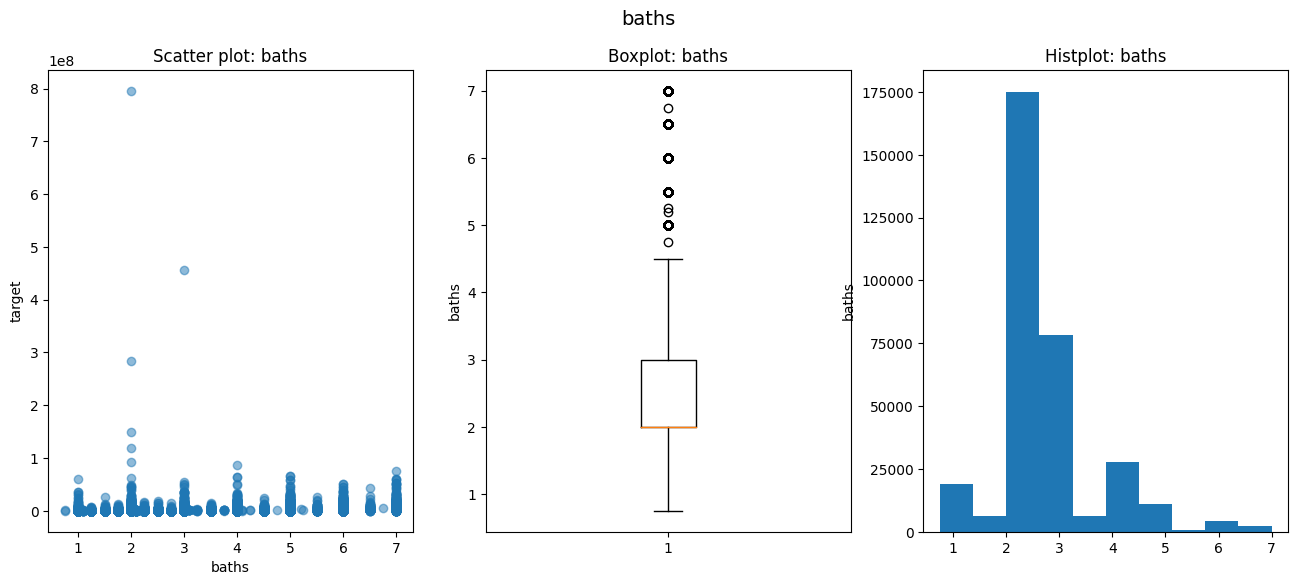

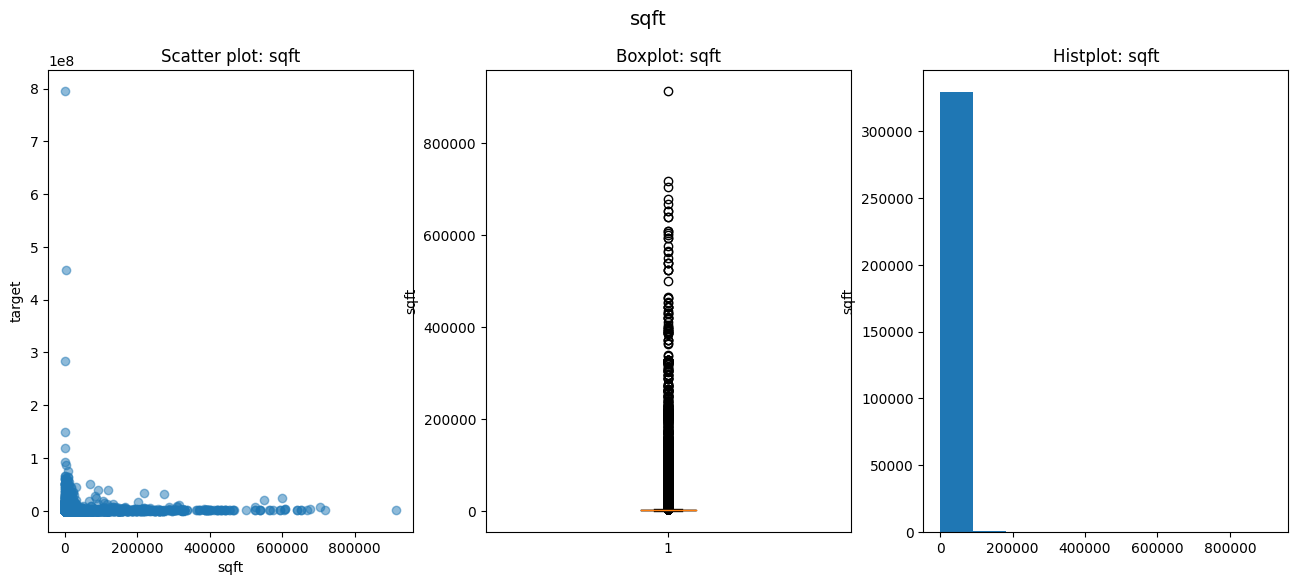

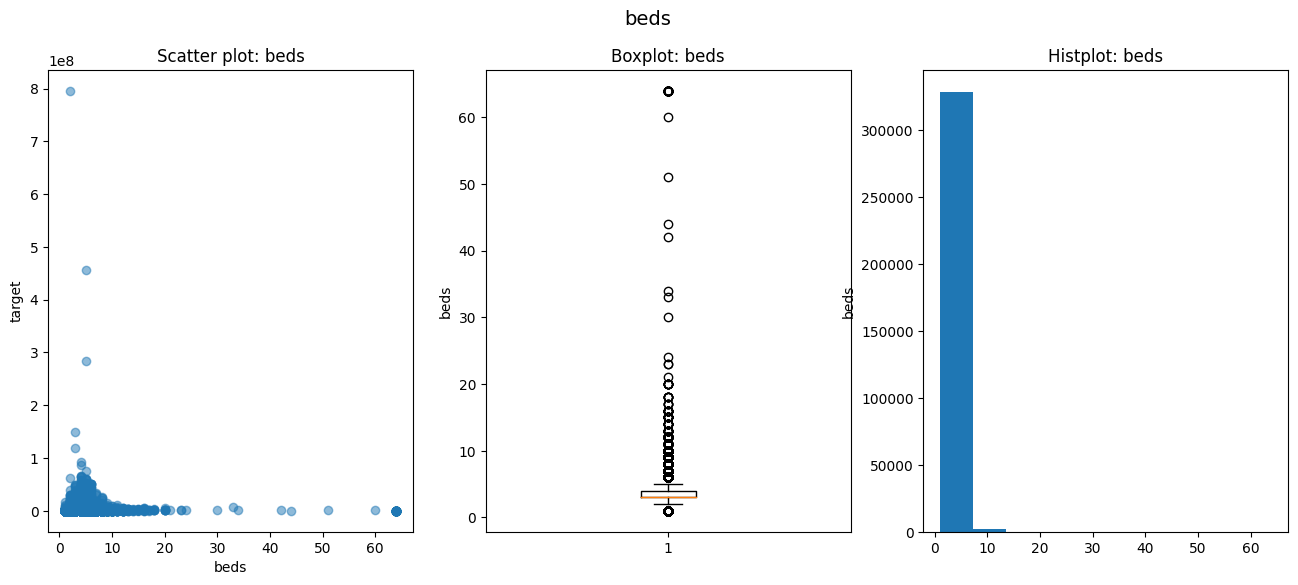

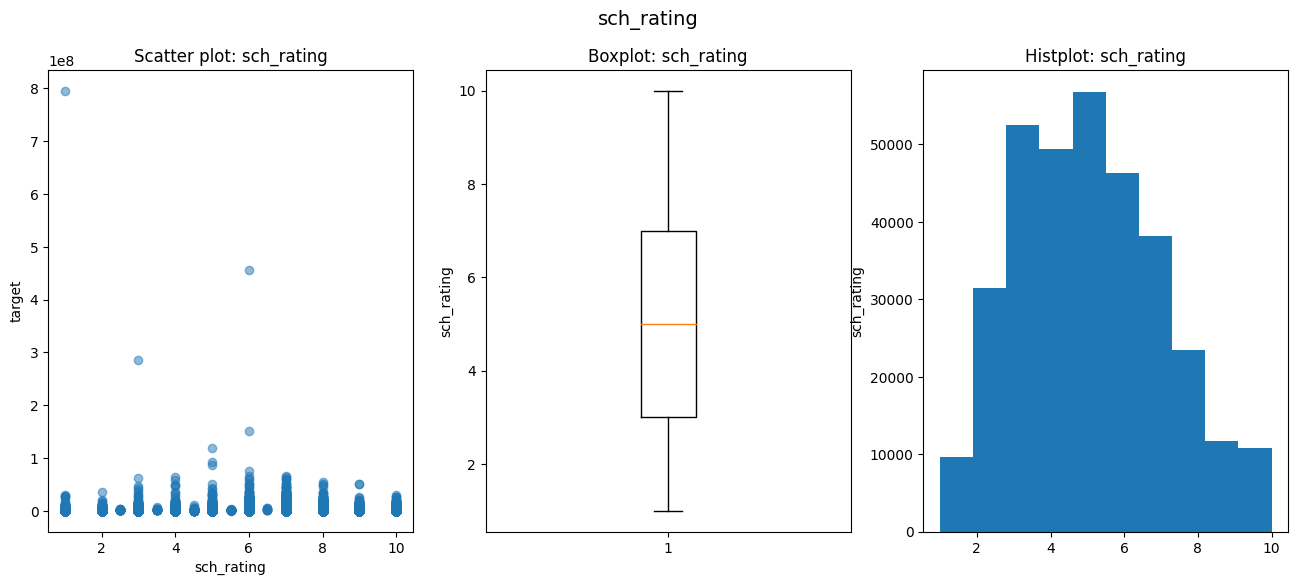

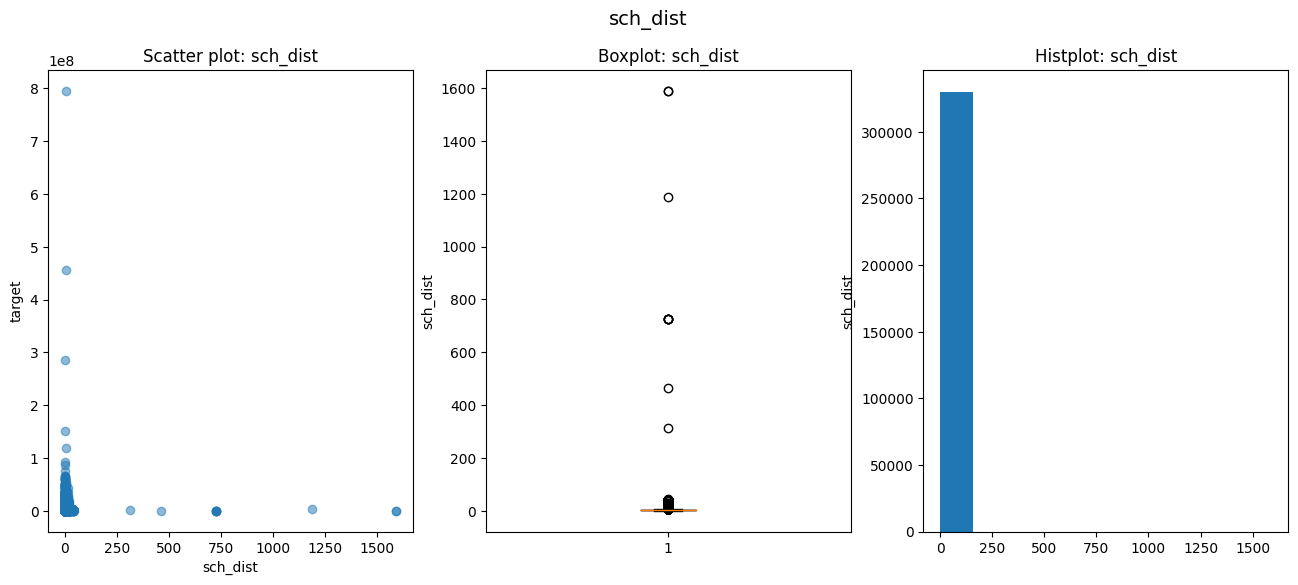

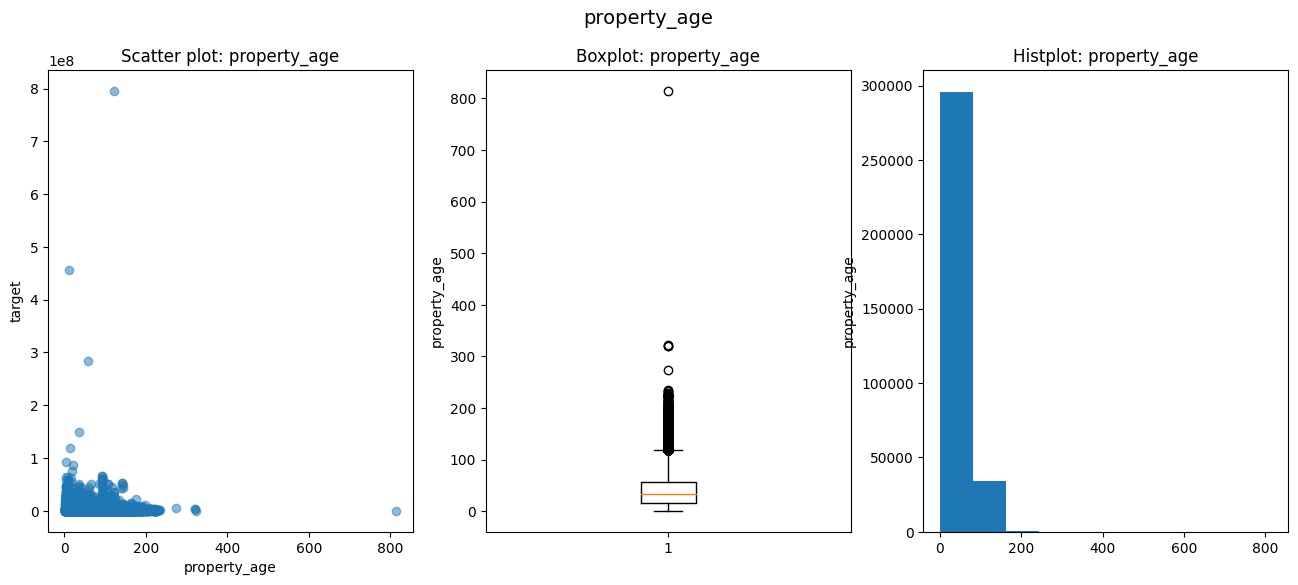

In [29]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r2[feature], r2['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r2[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r2[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

Графики baths выглядит немного лучше.

In [30]:
r3=r2.copy()

In [31]:
# найдем выбросы в признаке sqft
outliers_s, cleaned_s = outliers_z_score(r3, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_s.shape[0]}')
print(f'Результирующее число записей: {cleaned_s.shape[0]}')

Число выбросов по методу z-отклонения: 1934
Результирующее число записей: 328297


In [32]:
#посмотрим на значения попавшие в выбросы
#np.set_printoptions(formatter=dict(float='{:f}'.format))
#np.sort(outliers_s['sqft'].unique())
#посмотрим на объекты, попавшие в выбросы
#outliers_s.sort_values('sqft')[:50]
#посмотрим на сохраненные объекты
#cleaned_s.sort_values('sqft')

В выбросы попали объекты площадь, которых имеет совсем маленькие значения равные 1 или очень большие.

In [33]:
r3=cleaned_s.copy()

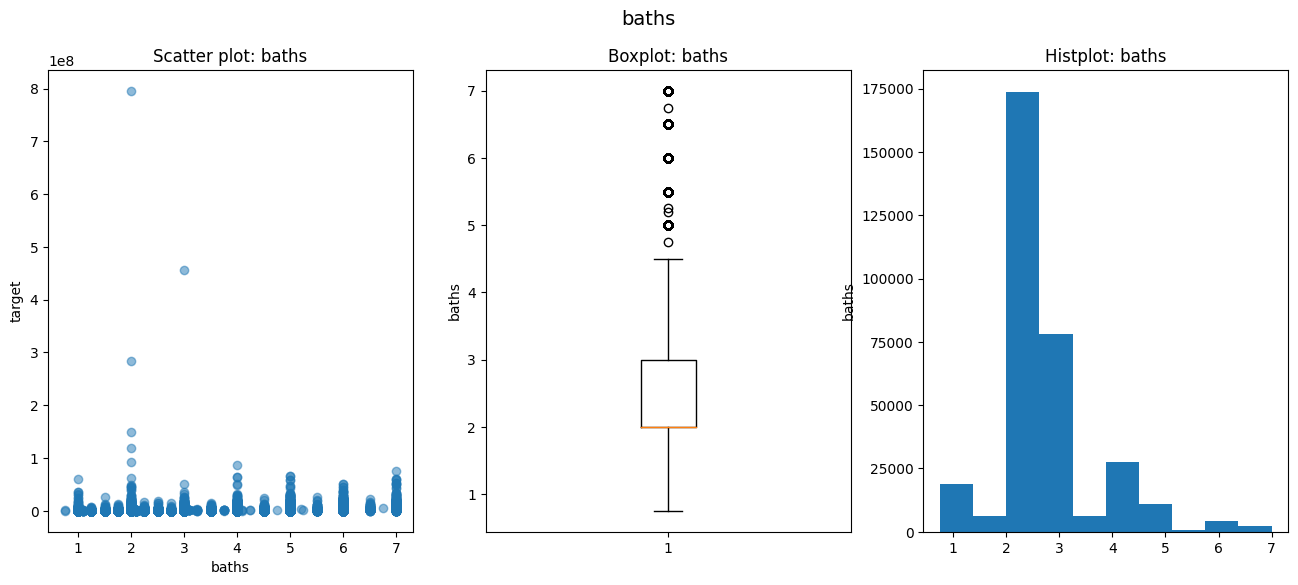

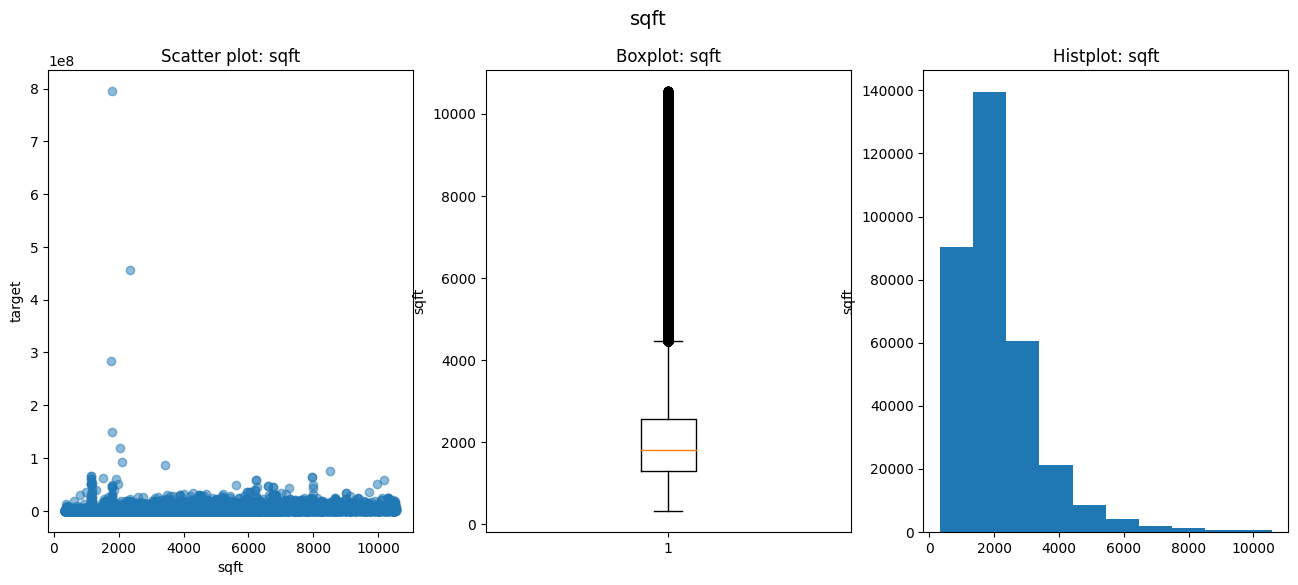

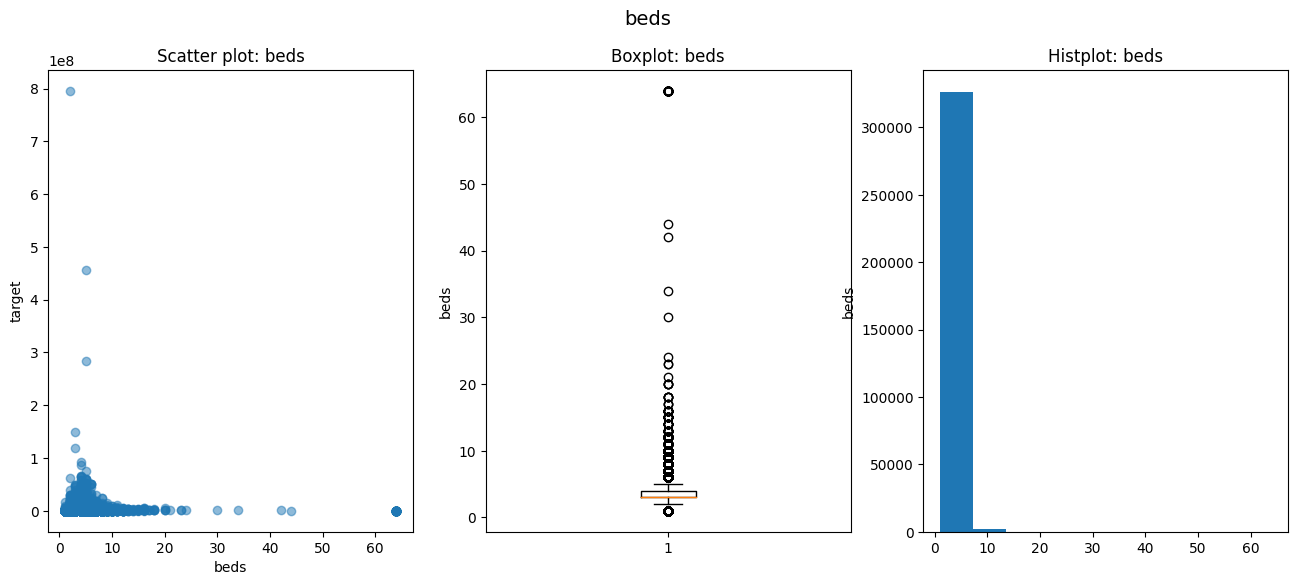

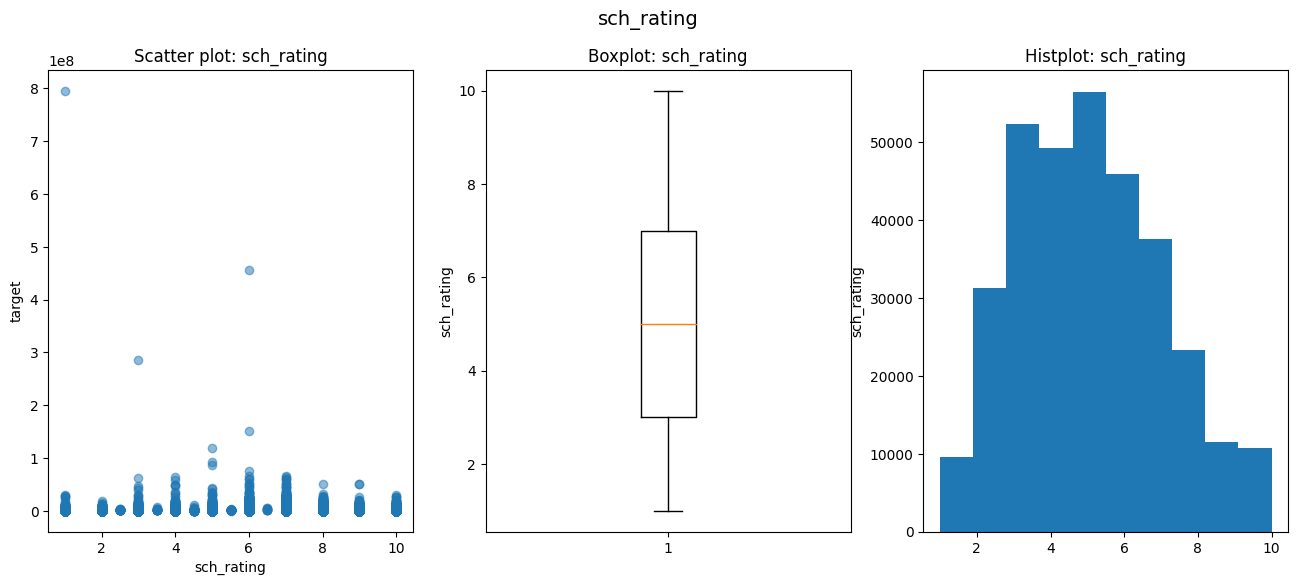

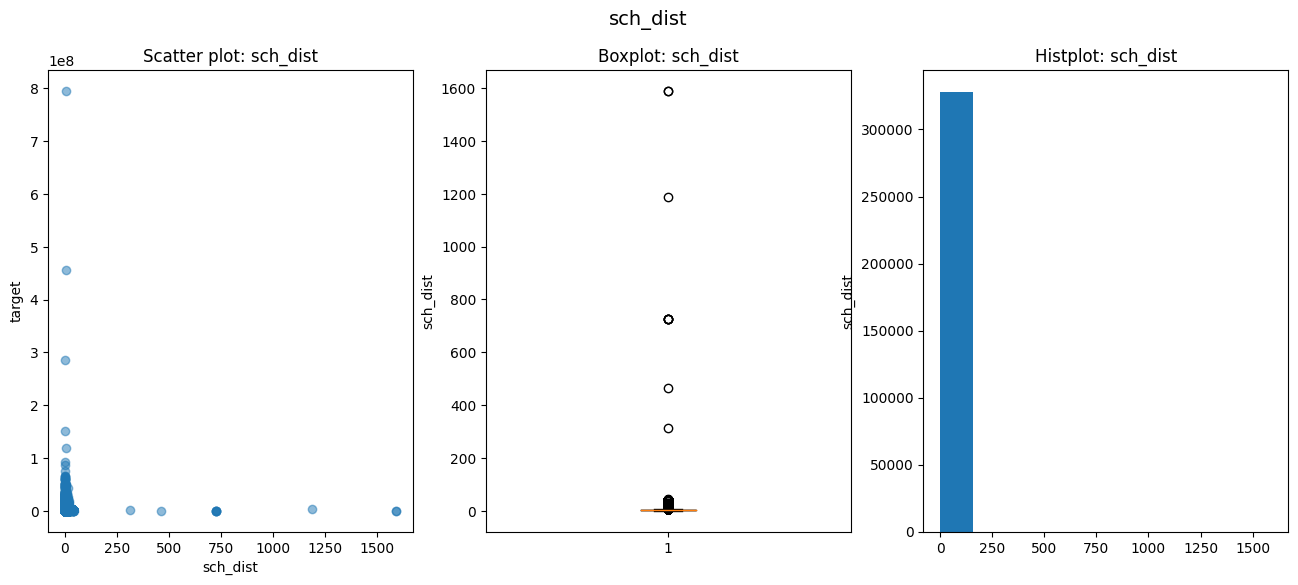

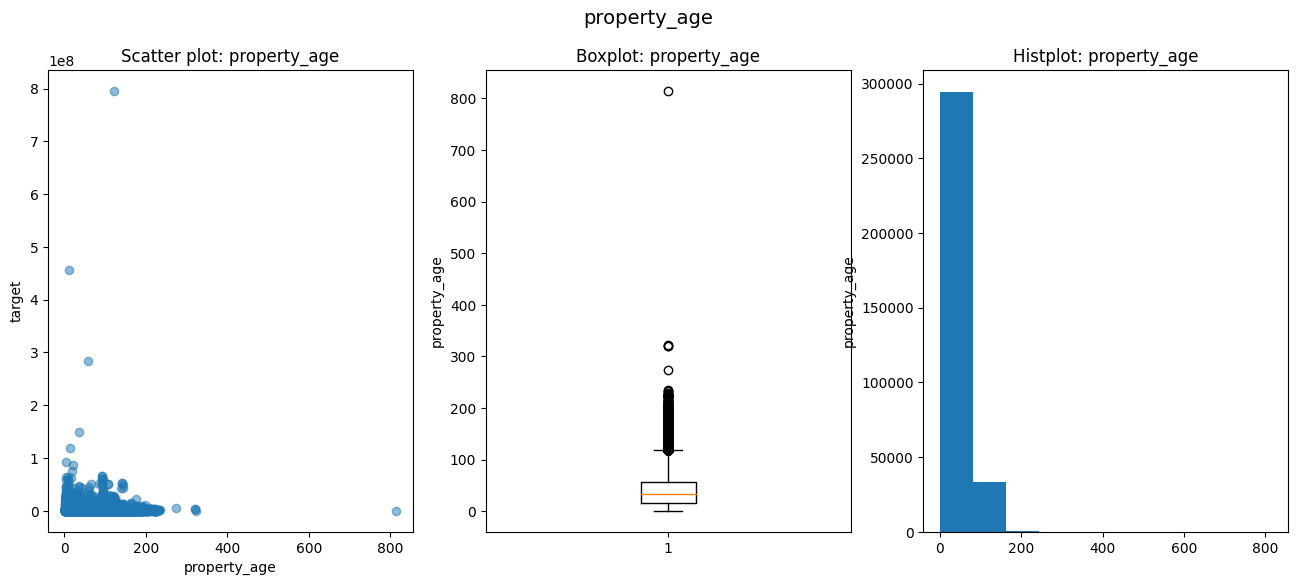

In [34]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r3[feature], r3['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r3[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r3[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

In [35]:
r4=r3.copy()

In [36]:
# найдем выбросы в признаке beds
outliers_bd, cleaned_bd = outliers_z_score(r4, 'beds', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_bd.shape[0]}')
print(f'Результирующее число записей: {cleaned_bd.shape[0]}')

Число выбросов по методу z-отклонения: 1757
Результирующее число записей: 326540


In [37]:
#посмотрим на значения признака, которые попали в выбросы
np.sort(outliers_bd['beds'].unique())

array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 20., 21.,
       23., 24., 30., 34., 42., 44., 64.])

In [38]:
#посмотрим как распределилась значения выбросов
#outliers_bd['beds'].value_counts().sort_index()
#outliers_bd[(outliers_bd['beds']/outliers_bd['baths']>3)]

Будем исходить из предположения, что на одну спальню приходится одна ванная комната, плюсом еще две ванных комнаты. Поэтому отберем из выбросов те, объекты, для которых число спален больше числа ванных комнат больше чем в три раза. Таких наблюдений 214 шт. Удалим их из датасета. 

In [39]:
#отберем индексы подходящих наблюдений
beds_more = outliers_bd[(outliers_bd['beds']/outliers_bd['baths']>3)].index
#удалим соответствующие строки из таблицы
r4.drop(beds_more, axis=0, inplace=True)

Снова отрисуем графики.

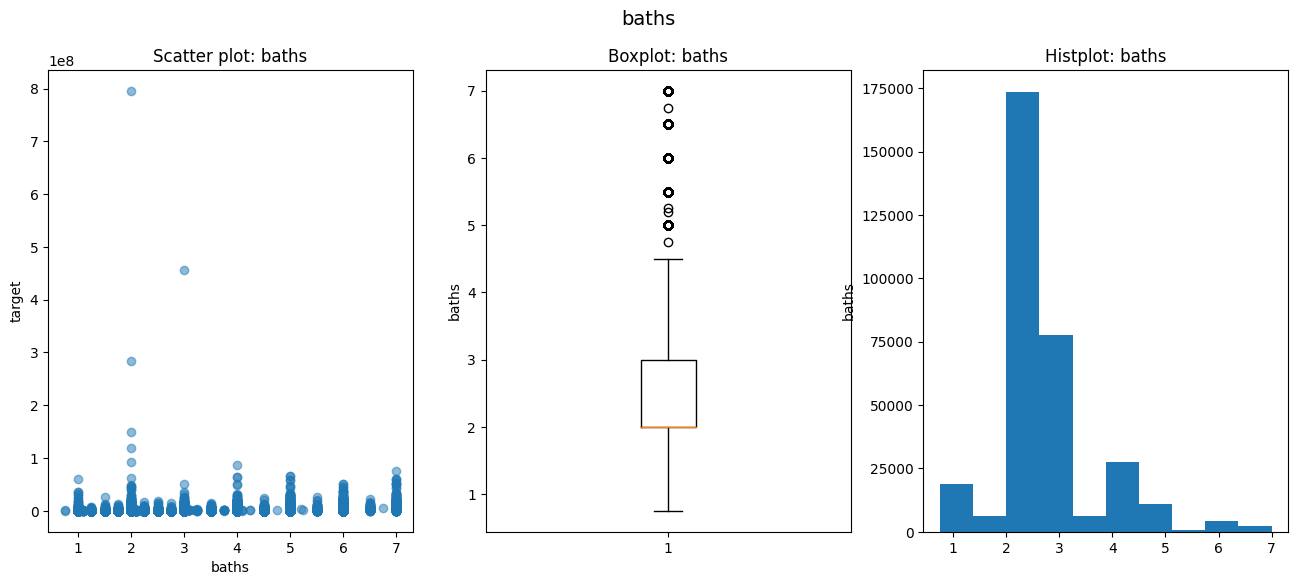

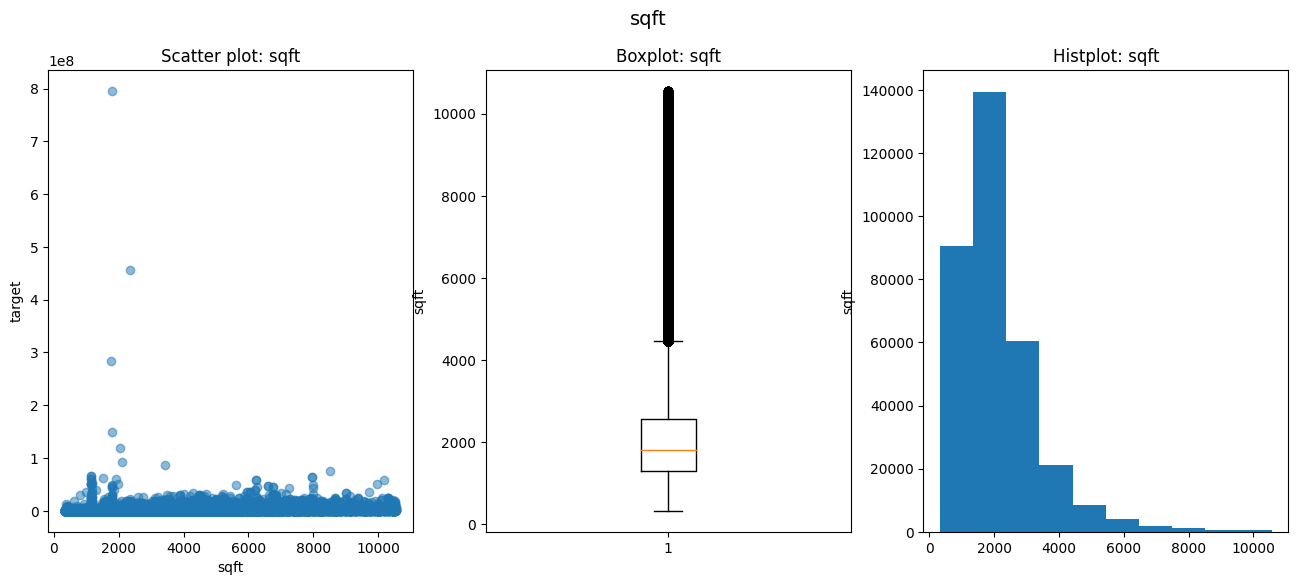

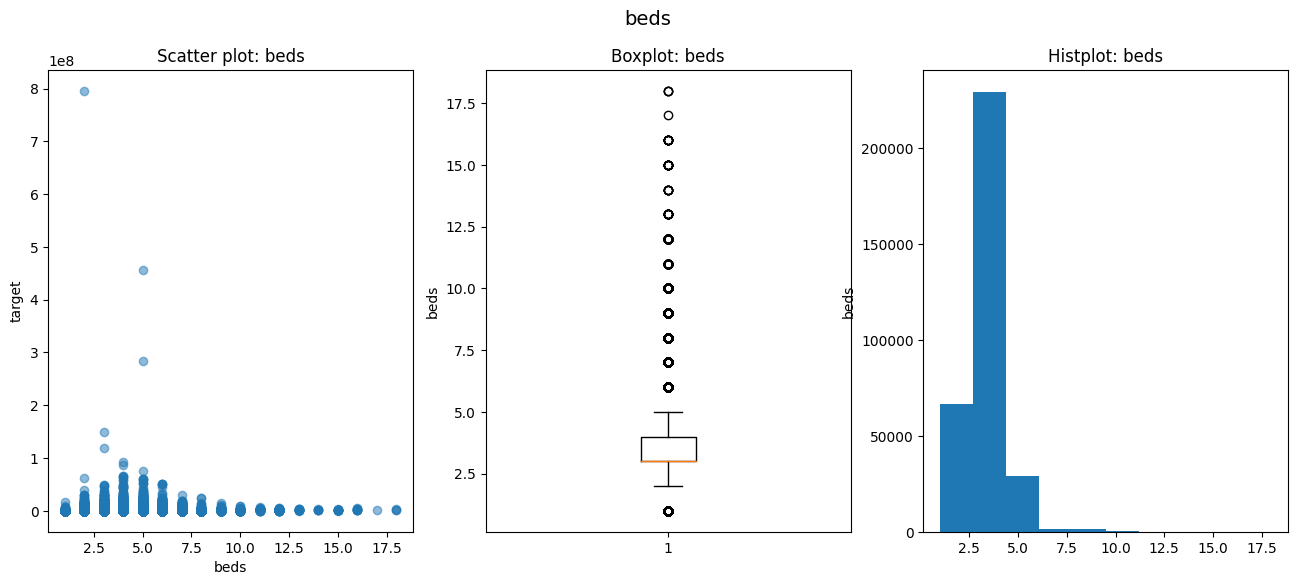

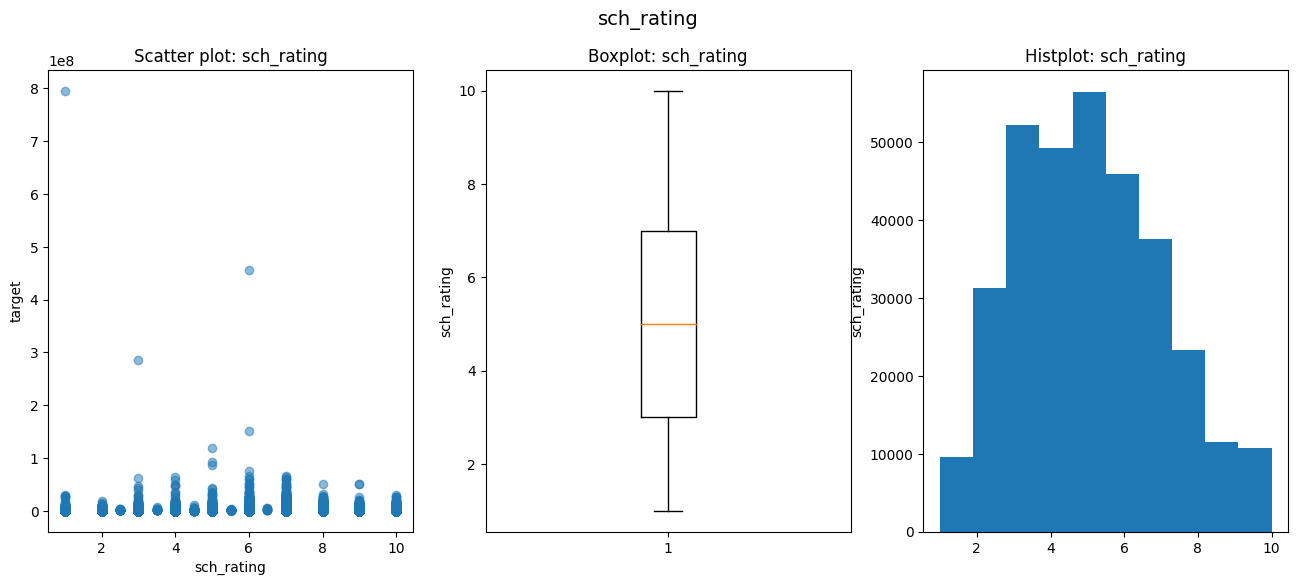

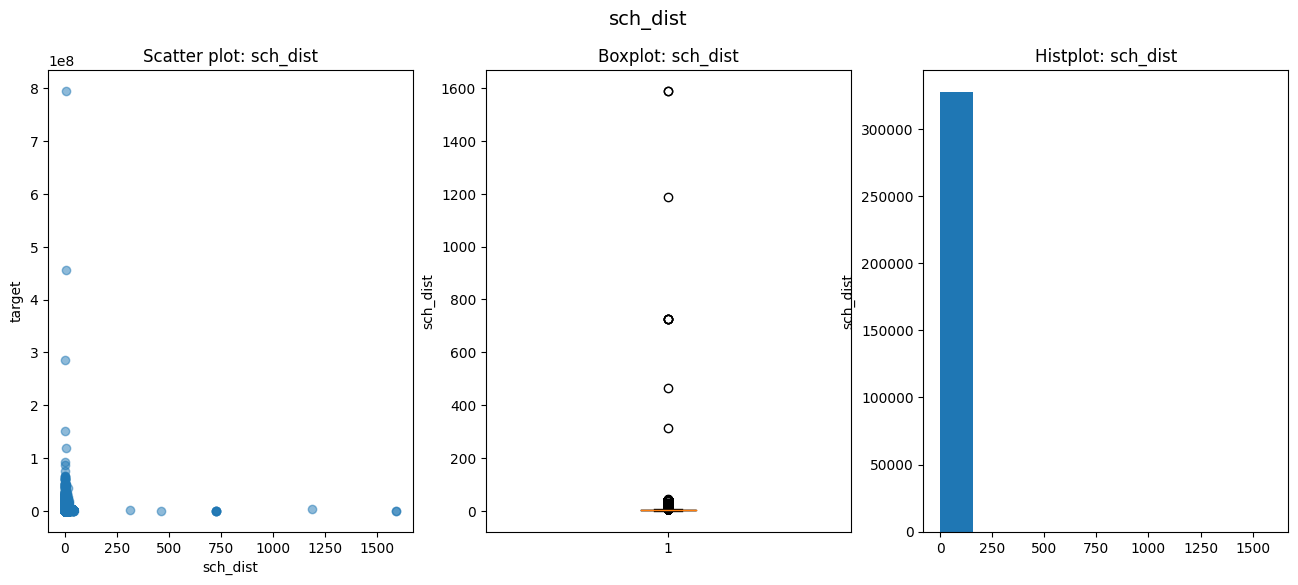

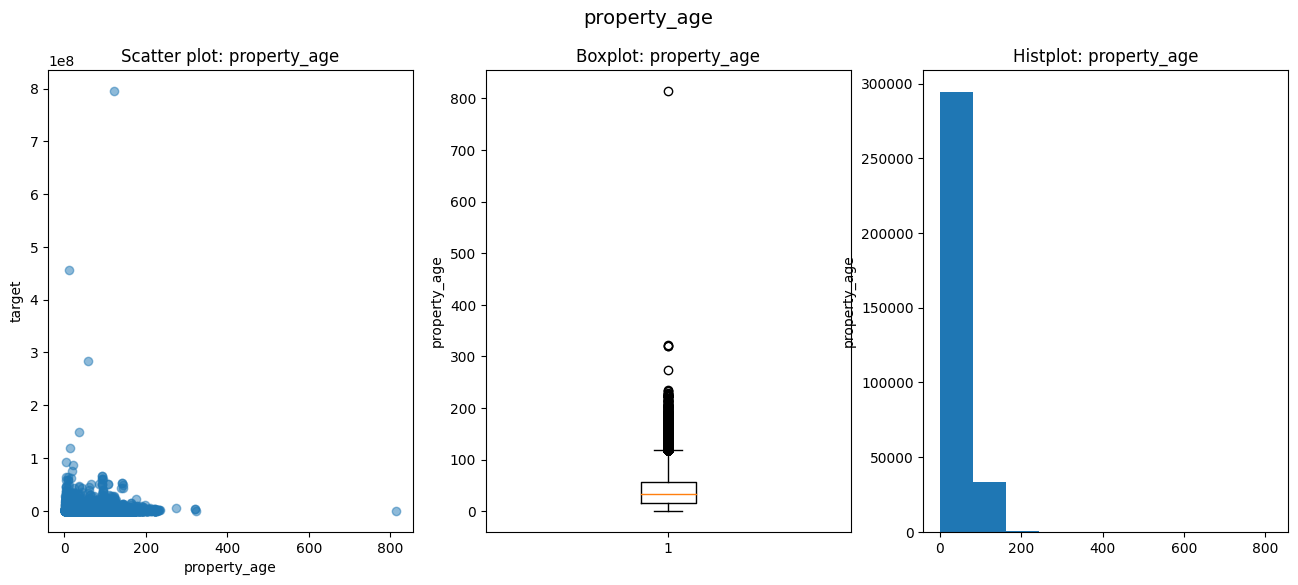

In [40]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r4[feature], r4['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r4[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r4[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

In [41]:
# найдем выбросы в признаке sch_rating
outliers_sr, cleaned_sr = outliers_z_score(r4, 'sch_rating', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_sr.shape[0]}')
print(f'Результирующее число записей: {cleaned_sr.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 328083


In [42]:
# найдем выбросы в признаке sch_dist
outliers_sd, cleaned_sd = outliers_z_score(r4, 'sch_dist', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_sd.shape[0]}')
print(f'Результирующее число записей: {cleaned_sd.shape[0]}')

Число выбросов по методу z-отклонения: 1117
Результирующее число записей: 326966


In [43]:
#посмотрим на значения признака, которые попали в выбросы
np.sort(outliers_sd['sch_dist'].unique())

array([  16.8 ,   16.9 ,   17.  ,   17.1 ,   17.2 ,   17.3 ,   17.4 ,
         17.5 ,   17.6 ,   17.7 ,   17.8 ,   17.9 ,   18.  ,   18.1 ,
         18.2 ,   18.3 ,   18.4 ,   18.5 ,   18.6 ,   18.7 ,   18.8 ,
         18.9 ,   19.  ,   19.1 ,   19.2 ,   19.3 ,   19.4 ,   19.5 ,
         19.6 ,   19.7 ,   19.8 ,   19.9 ,   20.  ,   20.1 ,   20.2 ,
         20.3 ,   20.4 ,   20.5 ,   20.6 ,   20.7 ,   20.8 ,   20.9 ,
         21.  ,   21.1 ,   21.2 ,   21.3 ,   21.4 ,   21.5 ,   21.6 ,
         21.7 ,   21.8 ,   21.9 ,   22.  ,   22.1 ,   22.2 ,   22.3 ,
         22.4 ,   22.5 ,   22.6 ,   22.7 ,   22.8 ,   22.9 ,   23.  ,
         23.04,   23.1 ,   23.2 ,   23.3 ,   23.4 ,   23.5 ,   23.6 ,
         23.7 ,   23.8 ,   24.  ,   24.1 ,   24.2 ,   24.3 ,   24.4 ,
         24.6 ,   24.7 ,   24.8 ,   24.9 ,   25.  ,   25.1 ,   25.2 ,
         25.4 ,   25.5 ,   25.6 ,   25.7 ,   25.8 ,   26.  ,   26.1 ,
         26.7 ,   27.  ,   29.  ,   36.3 ,   37.9 ,   39.7 ,   40.3 ,
         40.8 ,   45

In [44]:
#посмотрим на объекты попавшие в выбросы
#outliers_sd.sort_values('sch_dist', ascending =False)[:20]

Удалим объекты, в которых расстояние до школы больше 300 миль, так как среди них встречаются объекты, почти полностью дублирующие информацию в строках друг друга, а в качестве города указано needmore.

In [45]:
#отберем индексы подходящих наблюдений
dist_300 = outliers_sd[(outliers_sd['sch_dist']>300)].index
#удалим соответствующие строки из таблицы
r4.drop(dist_300, axis=0, inplace=True)

Сохраним остальные расстояния, так как в этих наблюдения ничего нет необычного. Скорее всего это загородные дома.

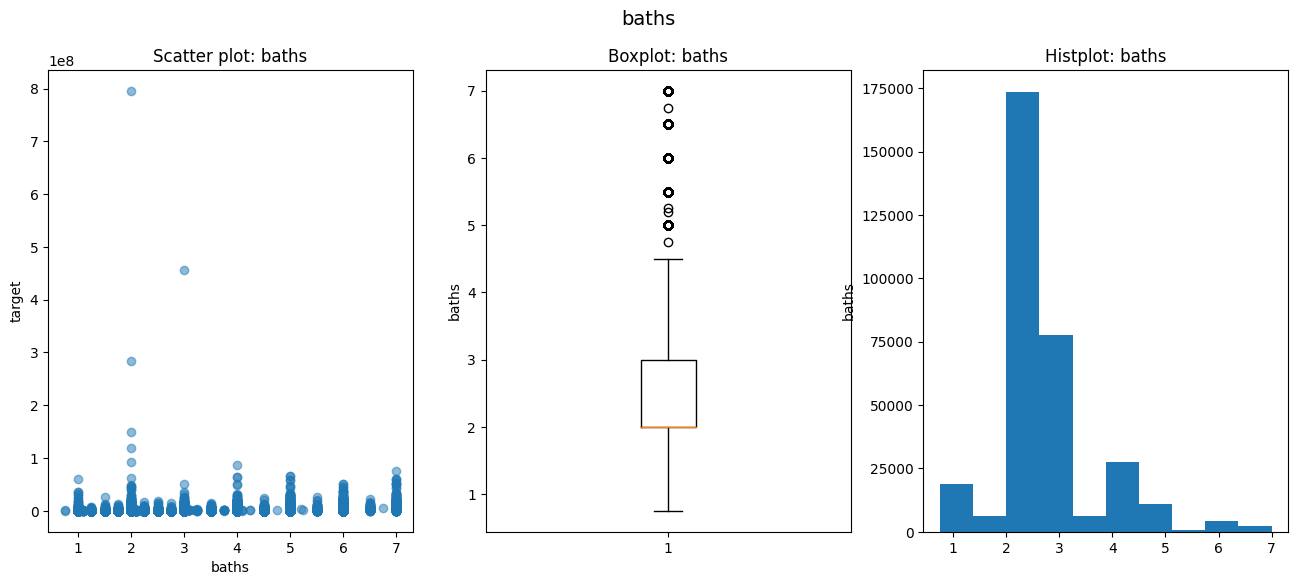

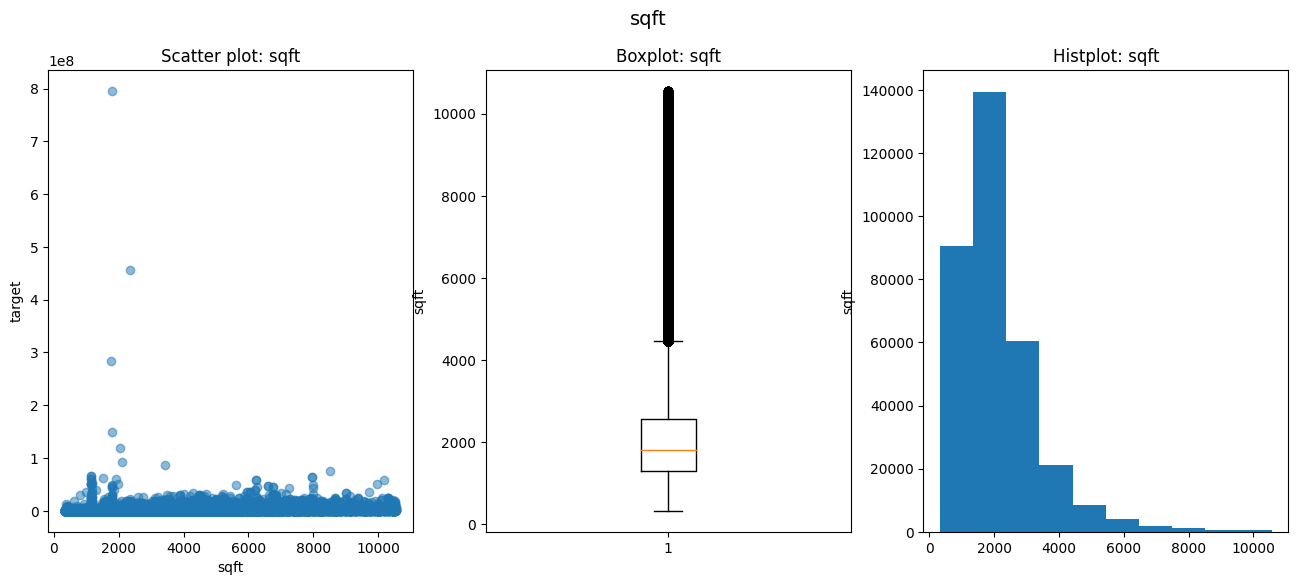

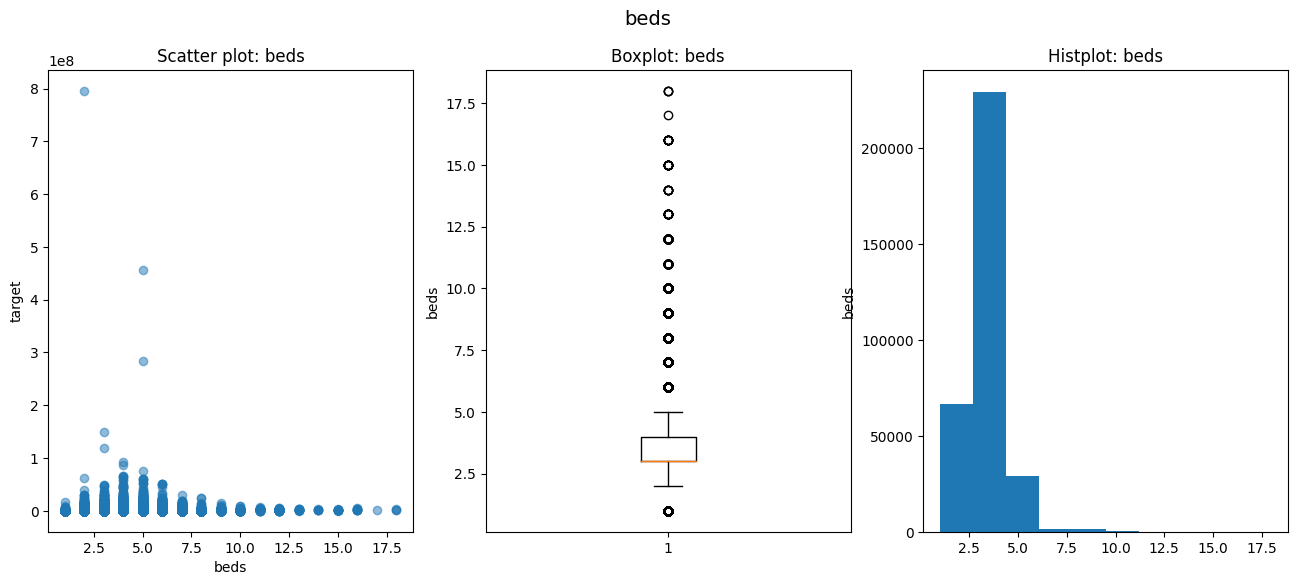

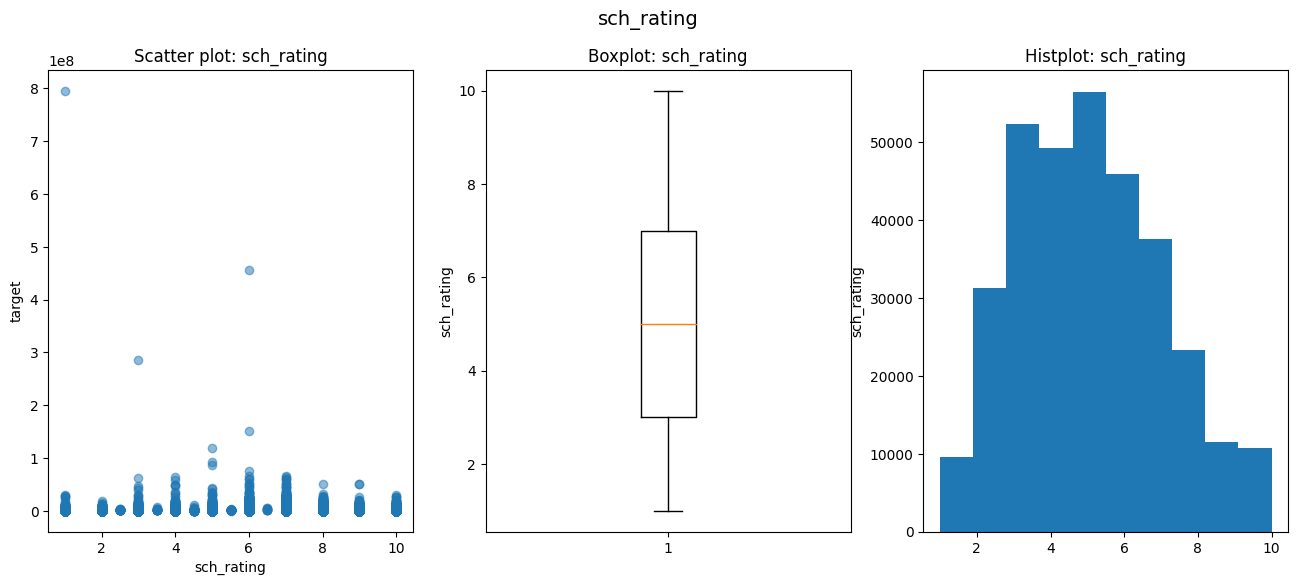

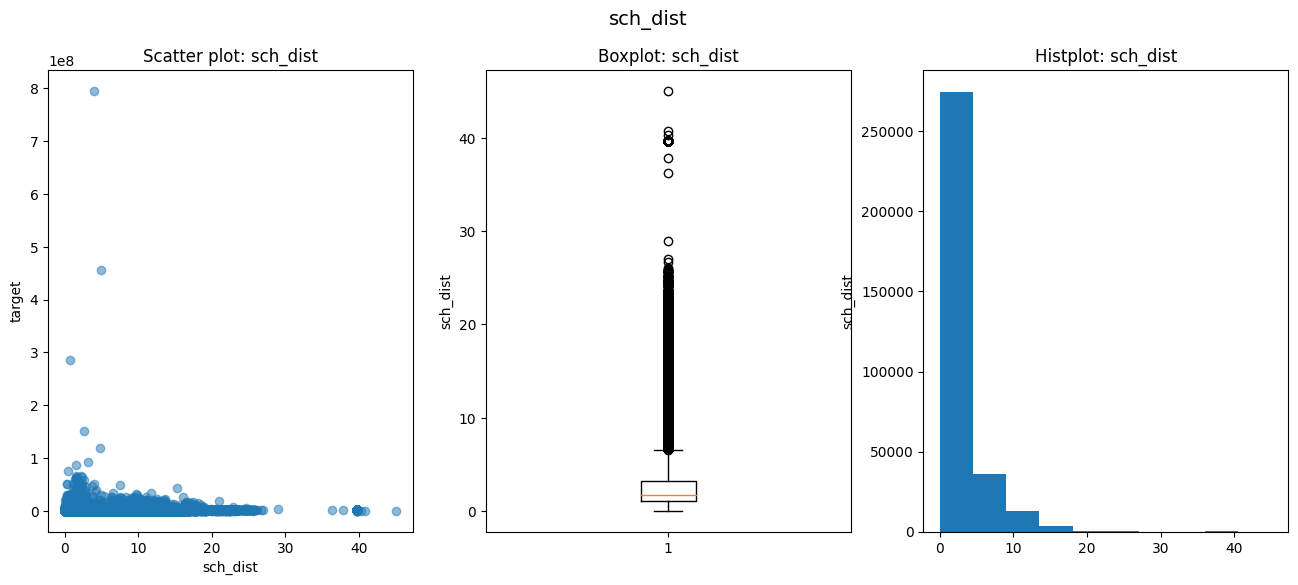

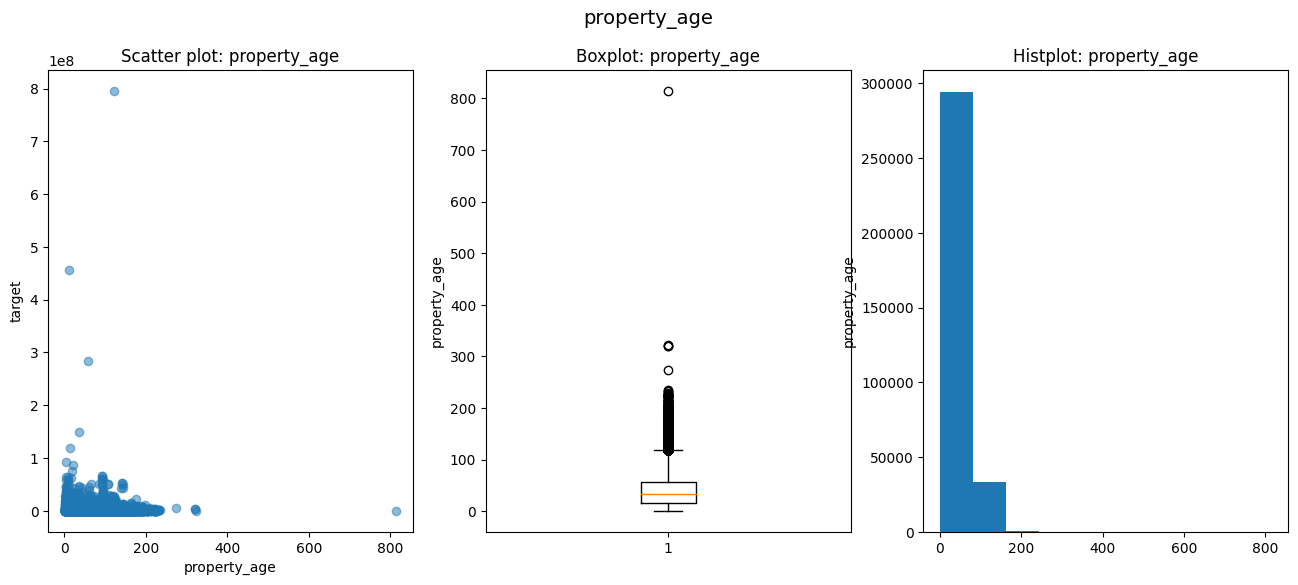

In [46]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r4[feature], r4['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r4[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r4[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

In [47]:
r5=r4.copy()

In [48]:
# найдем выбросы в признаке property_age
outliers_pa, cleaned_pa = outliers_z_score(r5, 'property_age', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_pa.shape[0]}')
print(f'Результирующее число записей: {cleaned_pa.shape[0]}')

Число выбросов по методу z-отклонения: 1
Результирующее число записей: 328072


In [49]:
#посмотрим на значения признака, которые попали в выбросы
np.sort(outliers_pa['property_age'].unique())

array([815.])

Удалим наблюдение с возрастом здания 815 лет из датасета.

In [50]:
#удалим объекты с property_age равным 815
#отберем индексы подходящих наблюдений
age_815 = outliers_pa[outliers_pa['property_age']==815].index
#удалим соответствующие строки из таблицы
r5.drop(age_815, axis=0, inplace=True)

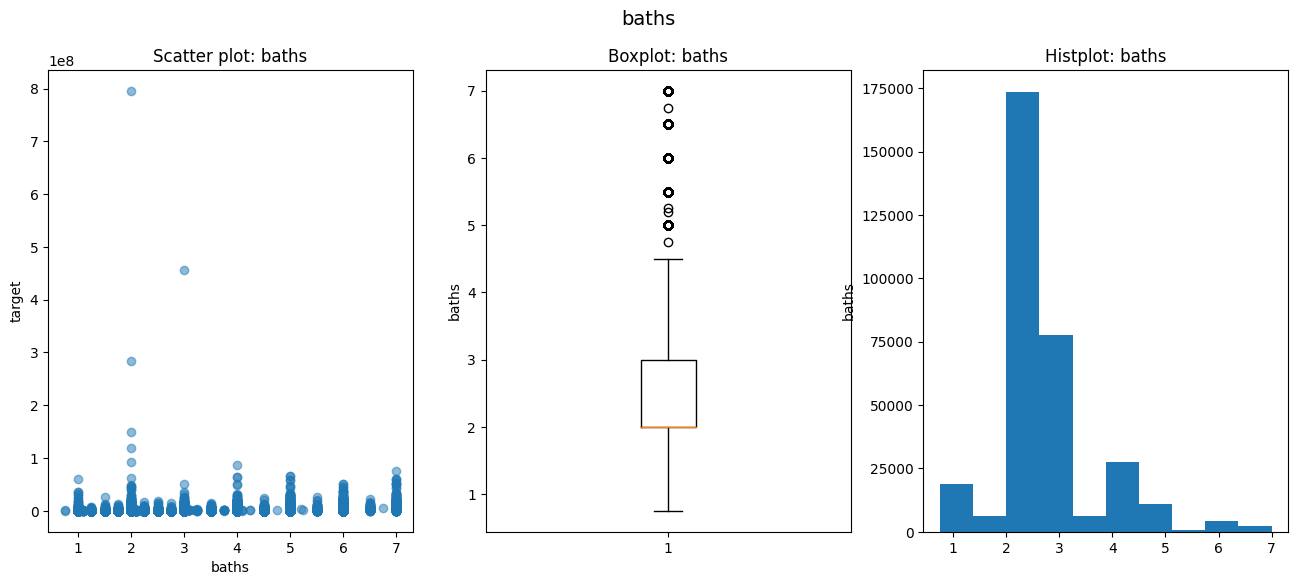

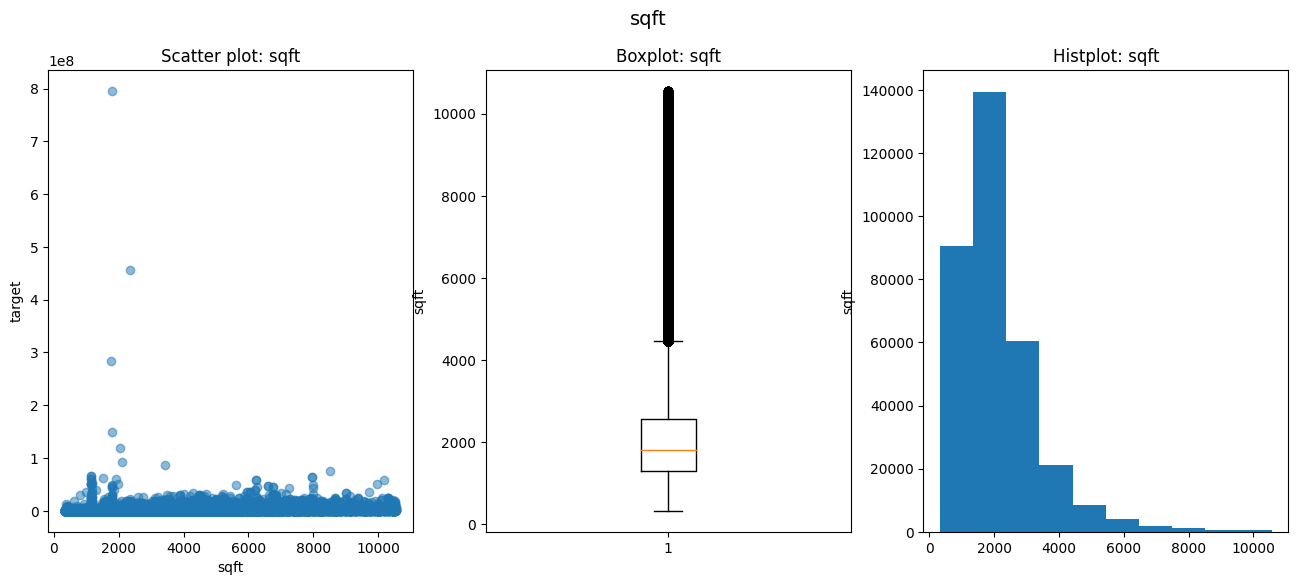

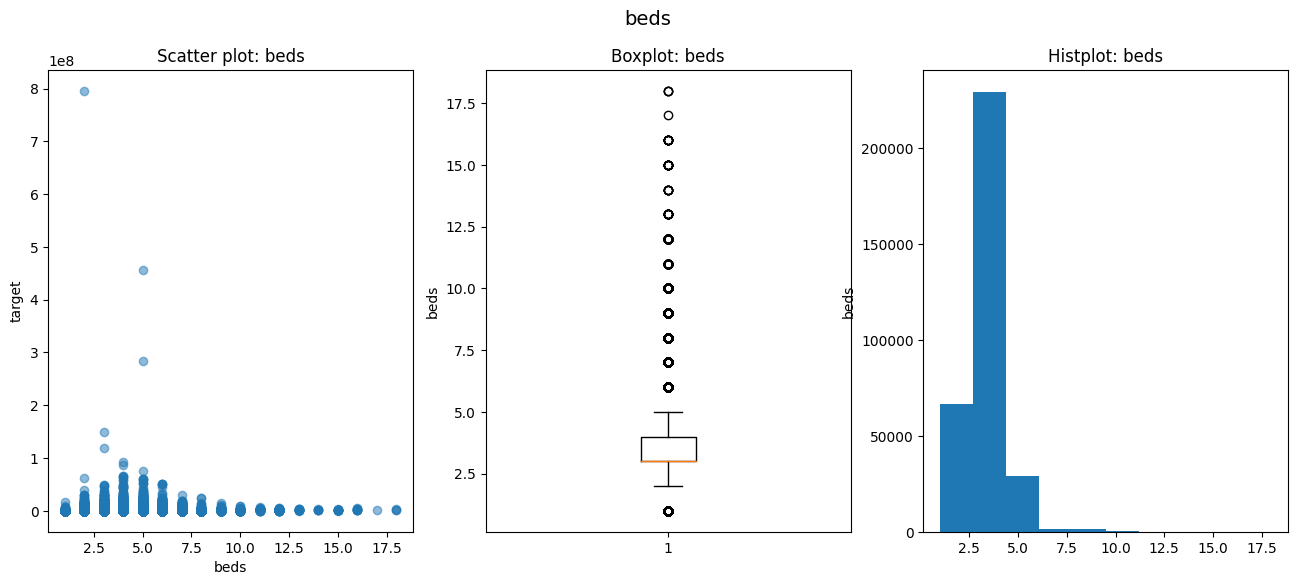

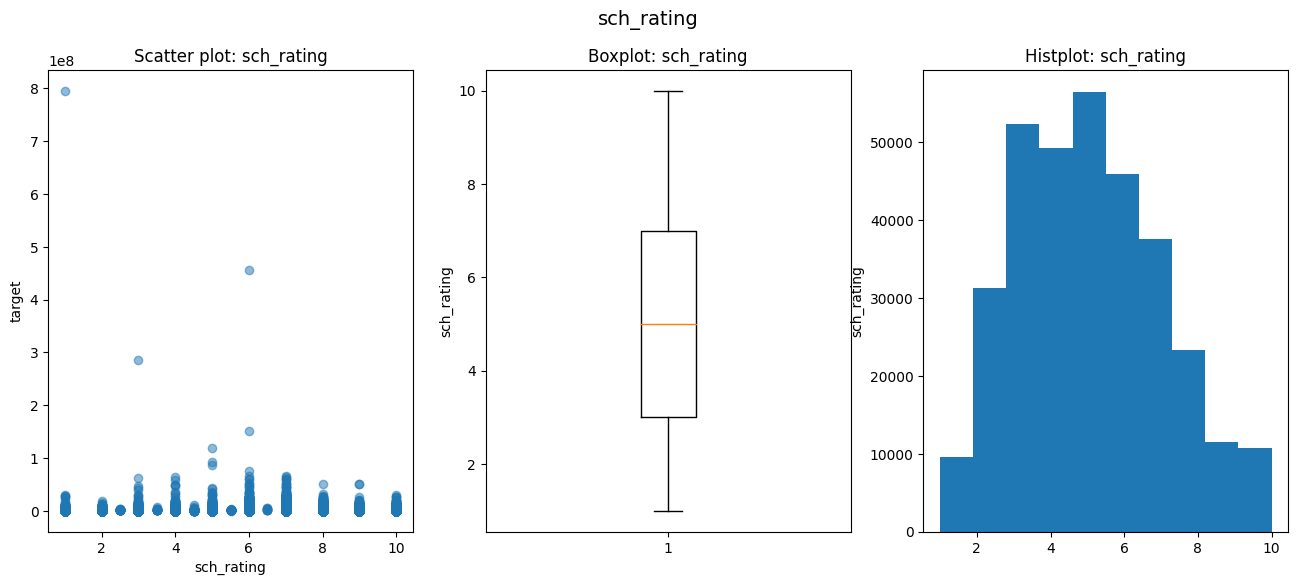

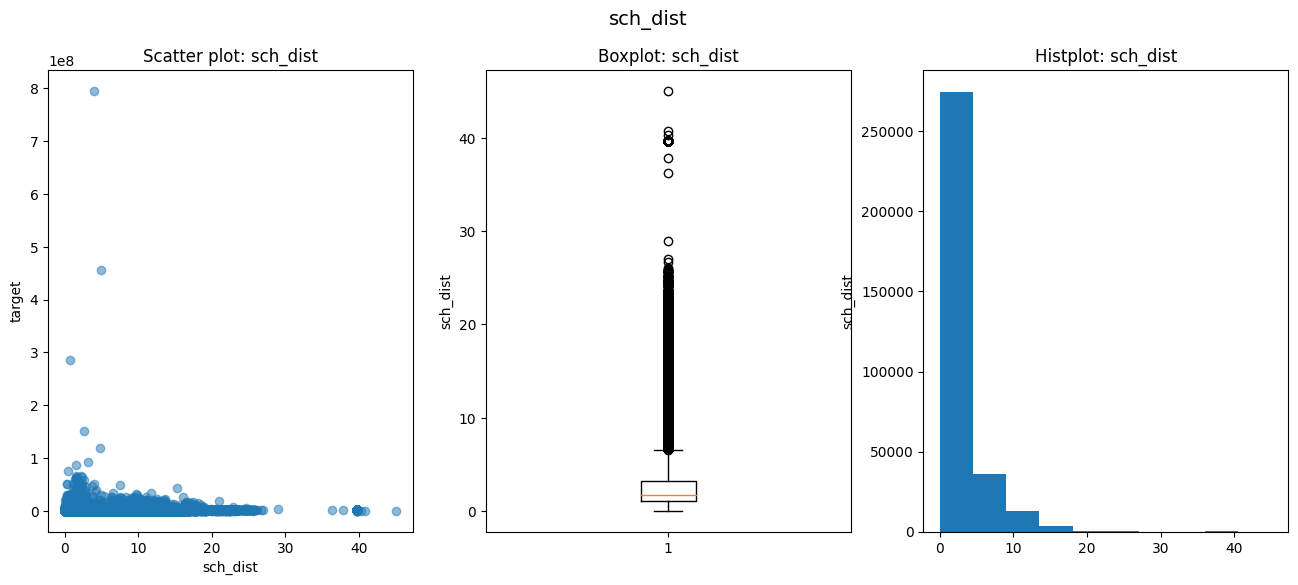

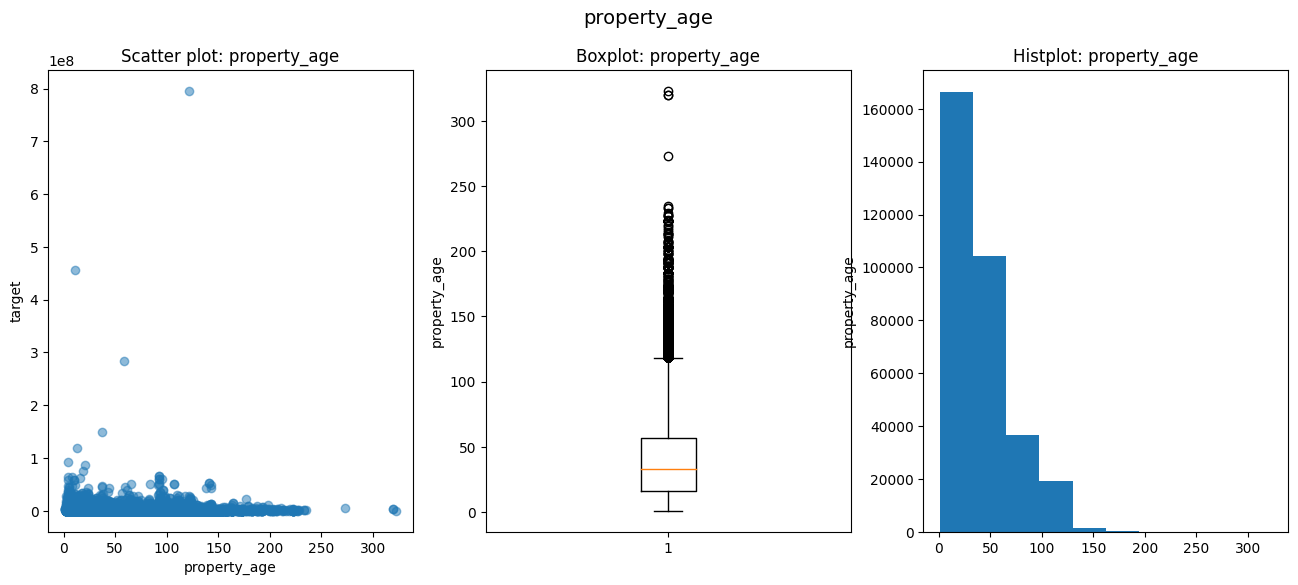

In [51]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r5[feature], r5['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r5[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r5[feature], bins=10 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

После анализа и удаления выбросов, все еще есть отдельнолежащие точки на графиках. Возможно это выбросы в признаке target.

In [52]:
r6=r5.copy()

Text(0, 0.5, 'target')

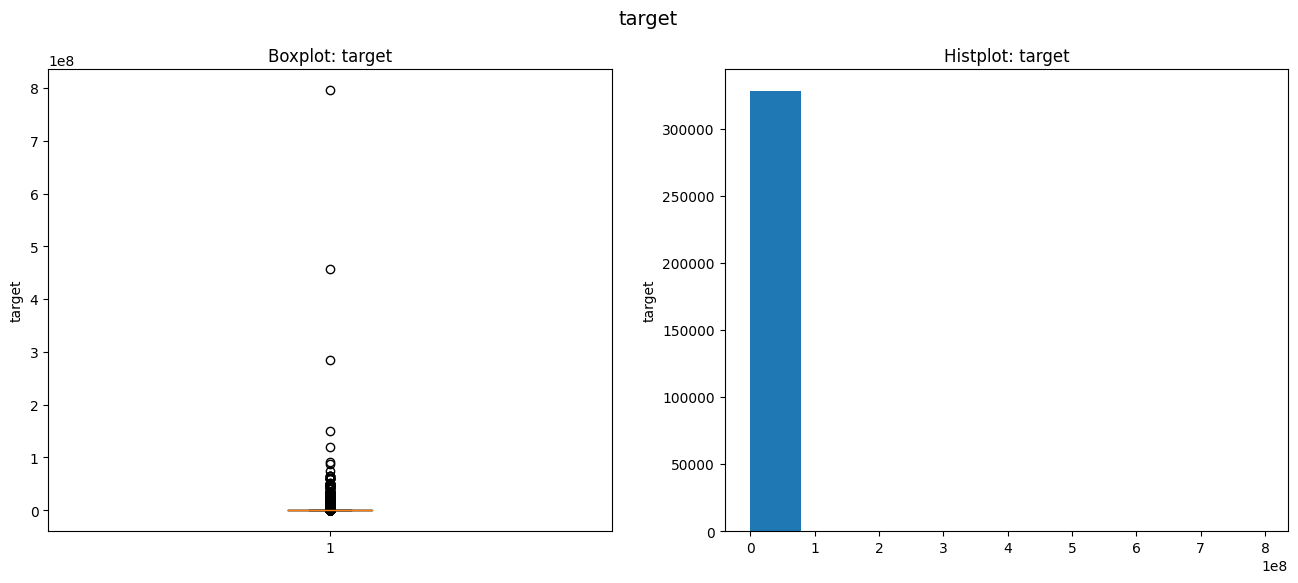

In [53]:
# отрисуем диаграммы для target до обработки от выбросов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('target', fontsize=14)

# Ящик с усами
ax1.boxplot(r6['target'])
ax1.set_title('Boxplot: target')
ax1.set_ylabel('target')
    
# Гистограмма
ax2.hist(r6['target'], bins=10 );
ax2.set_title(f'Histplot: target')
ax2.set_ylabel('target')

In [54]:
# найдем выбросы в признаке target
outliers_t, cleaned_t = outliers_z_score(r6, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_t.shape[0]}')
print(f'Результирующее число записей: {cleaned_t.shape[0]}')

Число выбросов по методу z-отклонения: 5201
Результирующее число записей: 322871


In [55]:
#посмотрим на значения признака, которые попали в выбросы
np.sort(outliers_t['target'].unique())

array([3.00000000e+00, 8.00000000e+02, 8.50000000e+02, ...,
       2.84621040e+08, 4.56602479e+08, 7.95979430e+08])

Анализ объектов, которые попали в число выбросов, показал , что это объекты с огромной стоимостью, и находятся в сити, боюсь, что такие данные сильно ухадшат модель, а еще среди этих объектов есть недвижимость, стоимость которой слишком мала и больше похожа на цену на кв.фут. Удалим эти объекты из датасета.

In [56]:
#удалим выбросы
r6=cleaned_t.copy()

Text(0, 0.5, 'target')

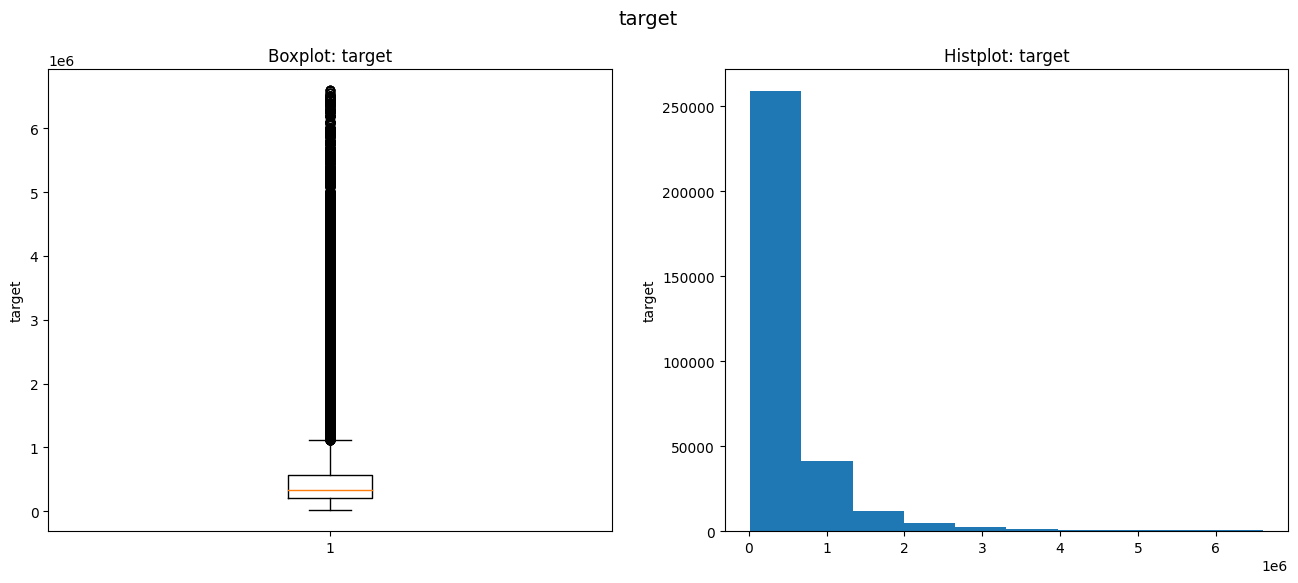

In [57]:
# отрисуем диаграммы для target после обработки от выбросов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('target', fontsize=14)

# Ящик с усами
ax1.boxplot(r6['target'])
ax1.set_title('Boxplot: target')
ax1.set_ylabel('target')
    
# Гистограмма
ax2.hist(r6['target'], bins=10 );
ax2.set_title(f'Histplot: target')
ax2.set_ylabel('target')

In [471]:
#r6['target'].describe()

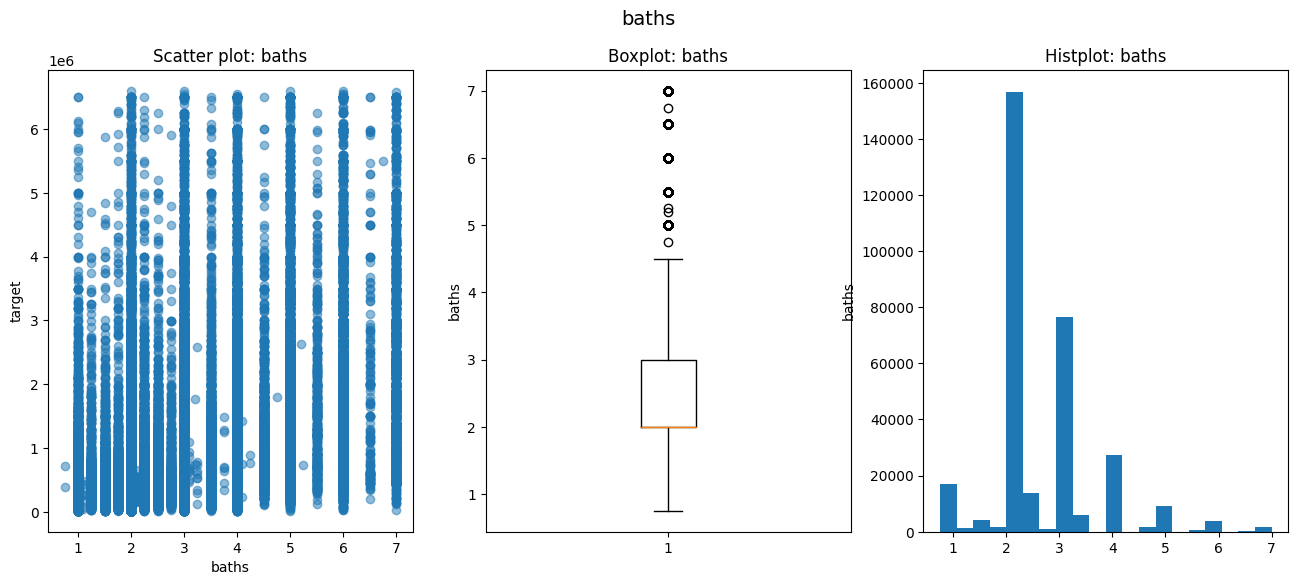

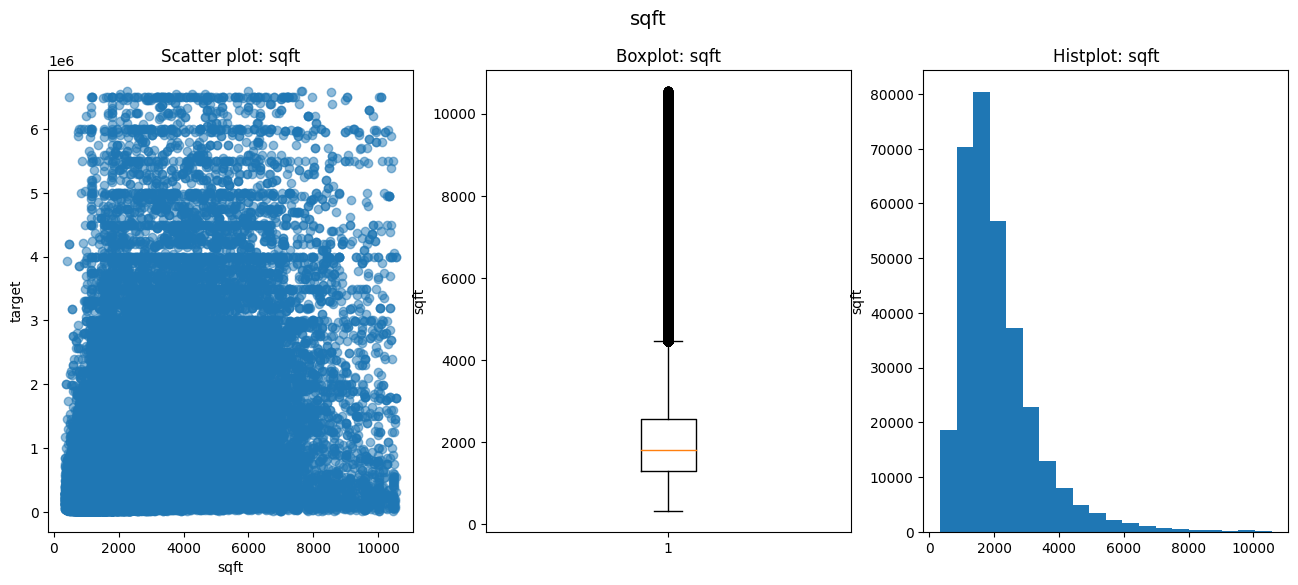

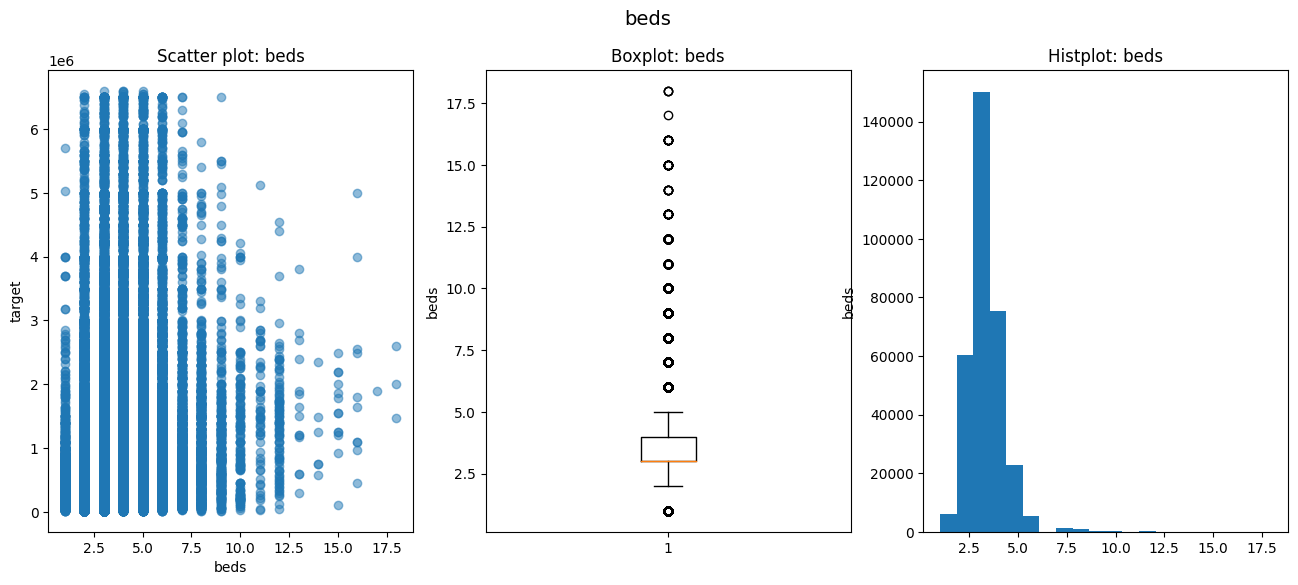

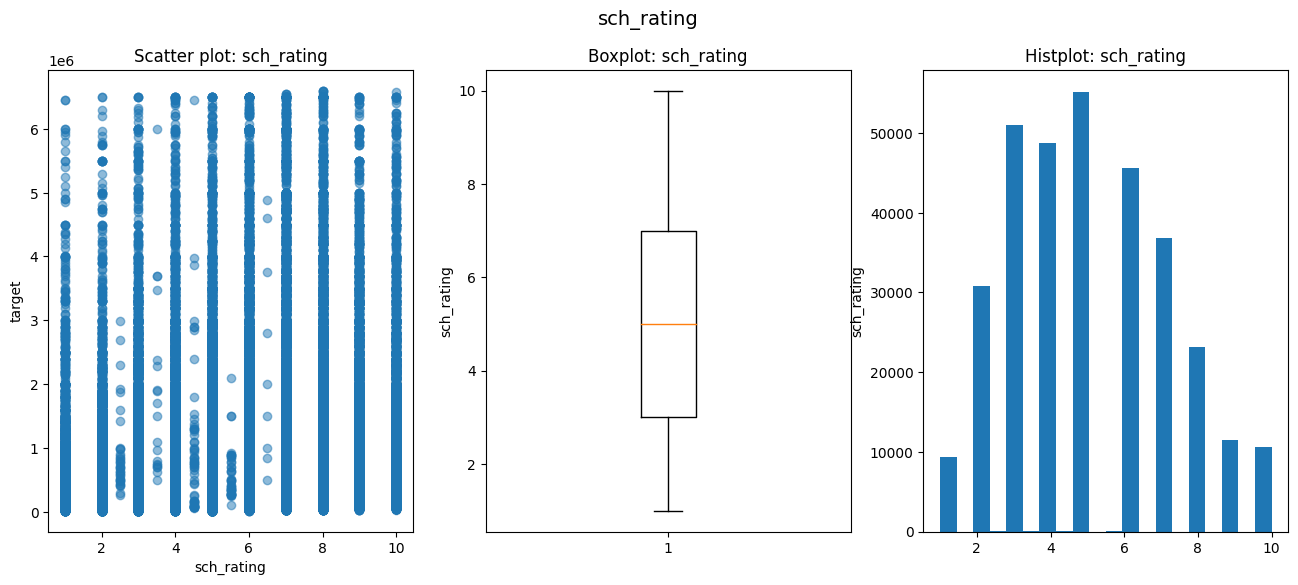

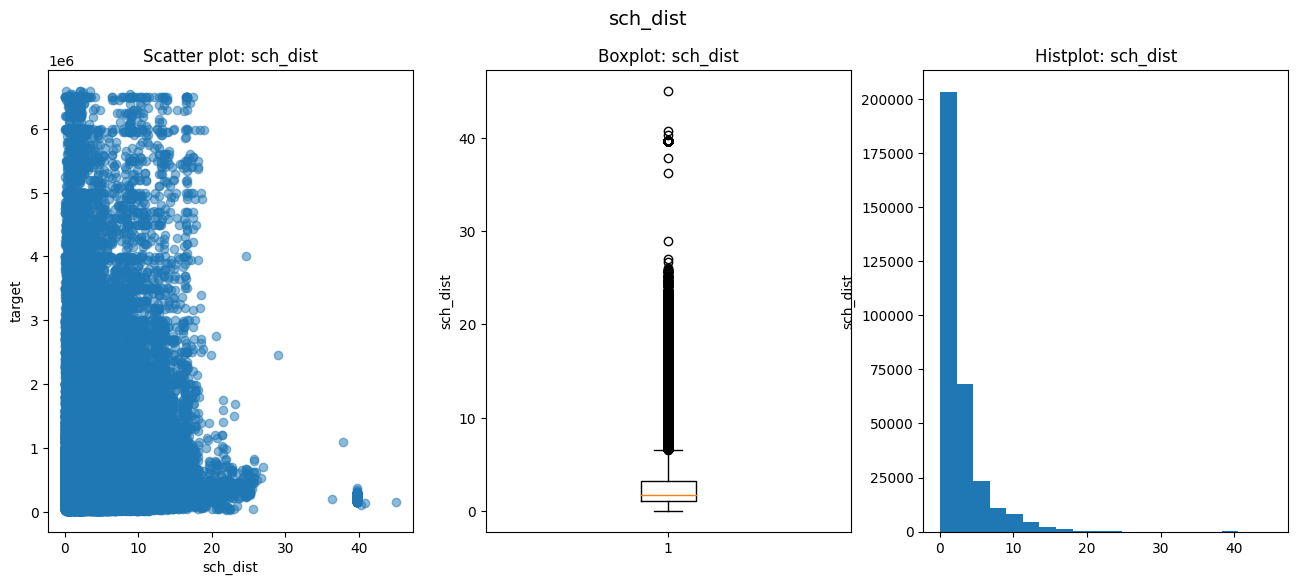

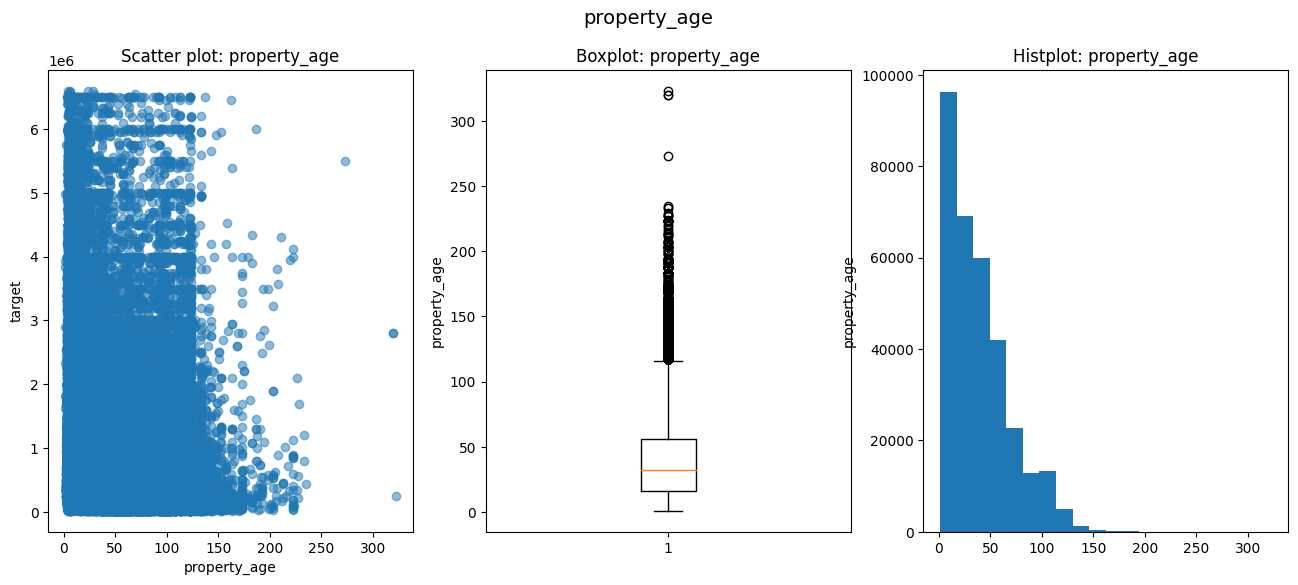

In [58]:
# Посмотрим как теперь выглядят графики рассеивания и ящика с усами для каждого признака
for feature in num_feature:
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(r6[feature], r6['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(r6[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)
    
    # Гистограмма
    ax3.hist(r6[feature], bins=20 );
    ax3.set_title(f'Histplot: {feature}')
    ax3.set_ylabel(feature)
    
    plt.show()

In [59]:
#посмотрим на описательные статистики
r6[num_feature].describe()

baths           sqft           beds     sch_rating  \
count  322871.000000  322871.000000  322871.000000  322871.000000   
mean        2.576294    2107.490687       3.246718       5.021890   
std         1.000561    1203.852610       1.055462       2.176896   
min         0.750000     332.000000       1.000000       1.000000   
25%         2.000000    1300.000000       3.000000       3.000000   
50%         2.000000    1806.000000       3.000000       5.000000   
75%         3.000000    2562.000000       4.000000       7.000000   
max         7.000000   10560.000000      18.000000      10.000000   

            sch_dist   property_age  
count  322871.000000  322871.000000  
mean        2.738508      38.168625  
std         3.016951      30.121593  
min         0.020000       1.000000  
25%         1.000000      16.000000  
50%         1.700000      32.000000  
75%         3.200000      56.000000  
max        45.100000     323.000000

В целом довольно неплохо. 
Благодаря очистке таблицы данных от выбросов, нам удалось улучшить качество, содержащейся в ней информации.


In [60]:
r7=r6.copy()

In [61]:
#проверим нормальность распределения величин с помощью теста Д'Агостино
#выдвигаем гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05 #задаем коэффициент значимости

for feature in num_feature:
    _, p = normaltest(r7[feature])
    print(f'Для признака {feature} p=', p)
    if p > alpha/2:
        print(H0)
    else:
        print(Ha)

Для признака baths p= 0.0
Данные не распределены нормально (мы отвергаем H0)
Для признака sqft p= 0.0
Данные не распределены нормально (мы отвергаем H0)
Для признака beds p= 0.0
Данные не распределены нормально (мы отвергаем H0)
Для признака sch_rating p= 0.0
Данные не распределены нормально (мы отвергаем H0)
Для признака sch_dist p= 0.0
Данные не распределены нормально (мы отвергаем H0)
Для признака property_age p= 0.0
Данные не распределены нормально (мы отвергаем H0)


In [62]:
#проверим нормальность распределения target с помощью теста Д'Агостино
#выдвигаем гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05 #задаем коэффициент значимости


_, p = normaltest(r7['target'])
print(f'Для признака target p=', p)
if p > alpha/2:
    print(H0)
else:
    print(Ha)

Для признака target p= 0.0
Данные не распределены нормально (мы отвергаем H0)


Так как количественные признаки не распределены нормально, то для оценки корреляционной зависимости между ними будем использовать корреляцию Спирмена. 

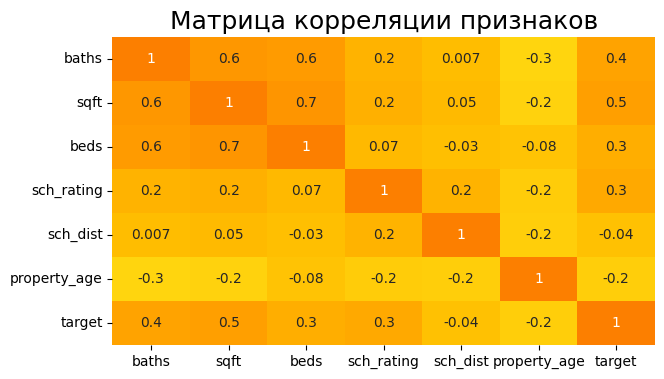

In [64]:
# построим матрицу корреляции для числовых признаков и target
fig = plt.figure(figsize=(7, 4))
heatmap = sns.heatmap(
    data = r7[['baths','sqft','beds','sch_rating','sch_dist','property_age','target']].corr(method='spearman'),
    annot = True,
    fmt = '.1g',
    vmin = -1,
    vmax = 1,
    cmap= 'Wistia',
    cbar=False
);
heatmap.set_title('Матрица корреляции признаков', fontsize=18);

По матрице корреляции можно сделать вывод, что имеет место мультиколлинеарность между признаками beds и sqft, так как коэффициент корреляции равен 0.7. Средняя связь с коэффициентом корреляции 0.6 наблюдается между признаками: baths и sqft, beds и baths. Слабая связь с коэффициентом корреляции 0.4 наблюдается между признаками: baths и target, target и sqft.

После подгрузки предобработанного файла признак zipcode стал числовым, что не совсем корректно так как zipcode указывает нам на район расположения объекта исправим это и приступим посмотрим на выбросы в числовых данных

In [65]:
r7['zipcode'] = r7['zipcode'].astype(str)

Посмотрим на распределение признака target в зависимости от категориальных признаков. Для этого построим диаграммы. Но прежде логарифмируем признак target.

In [66]:
#логарифмируем признак target для построения диаграмм категориальных признаков
r7['log_target'] = r7['target'].apply(lambda x: np.log(x + 1))

Text(0.5, 1.0, 'Boxplot: capital_state')

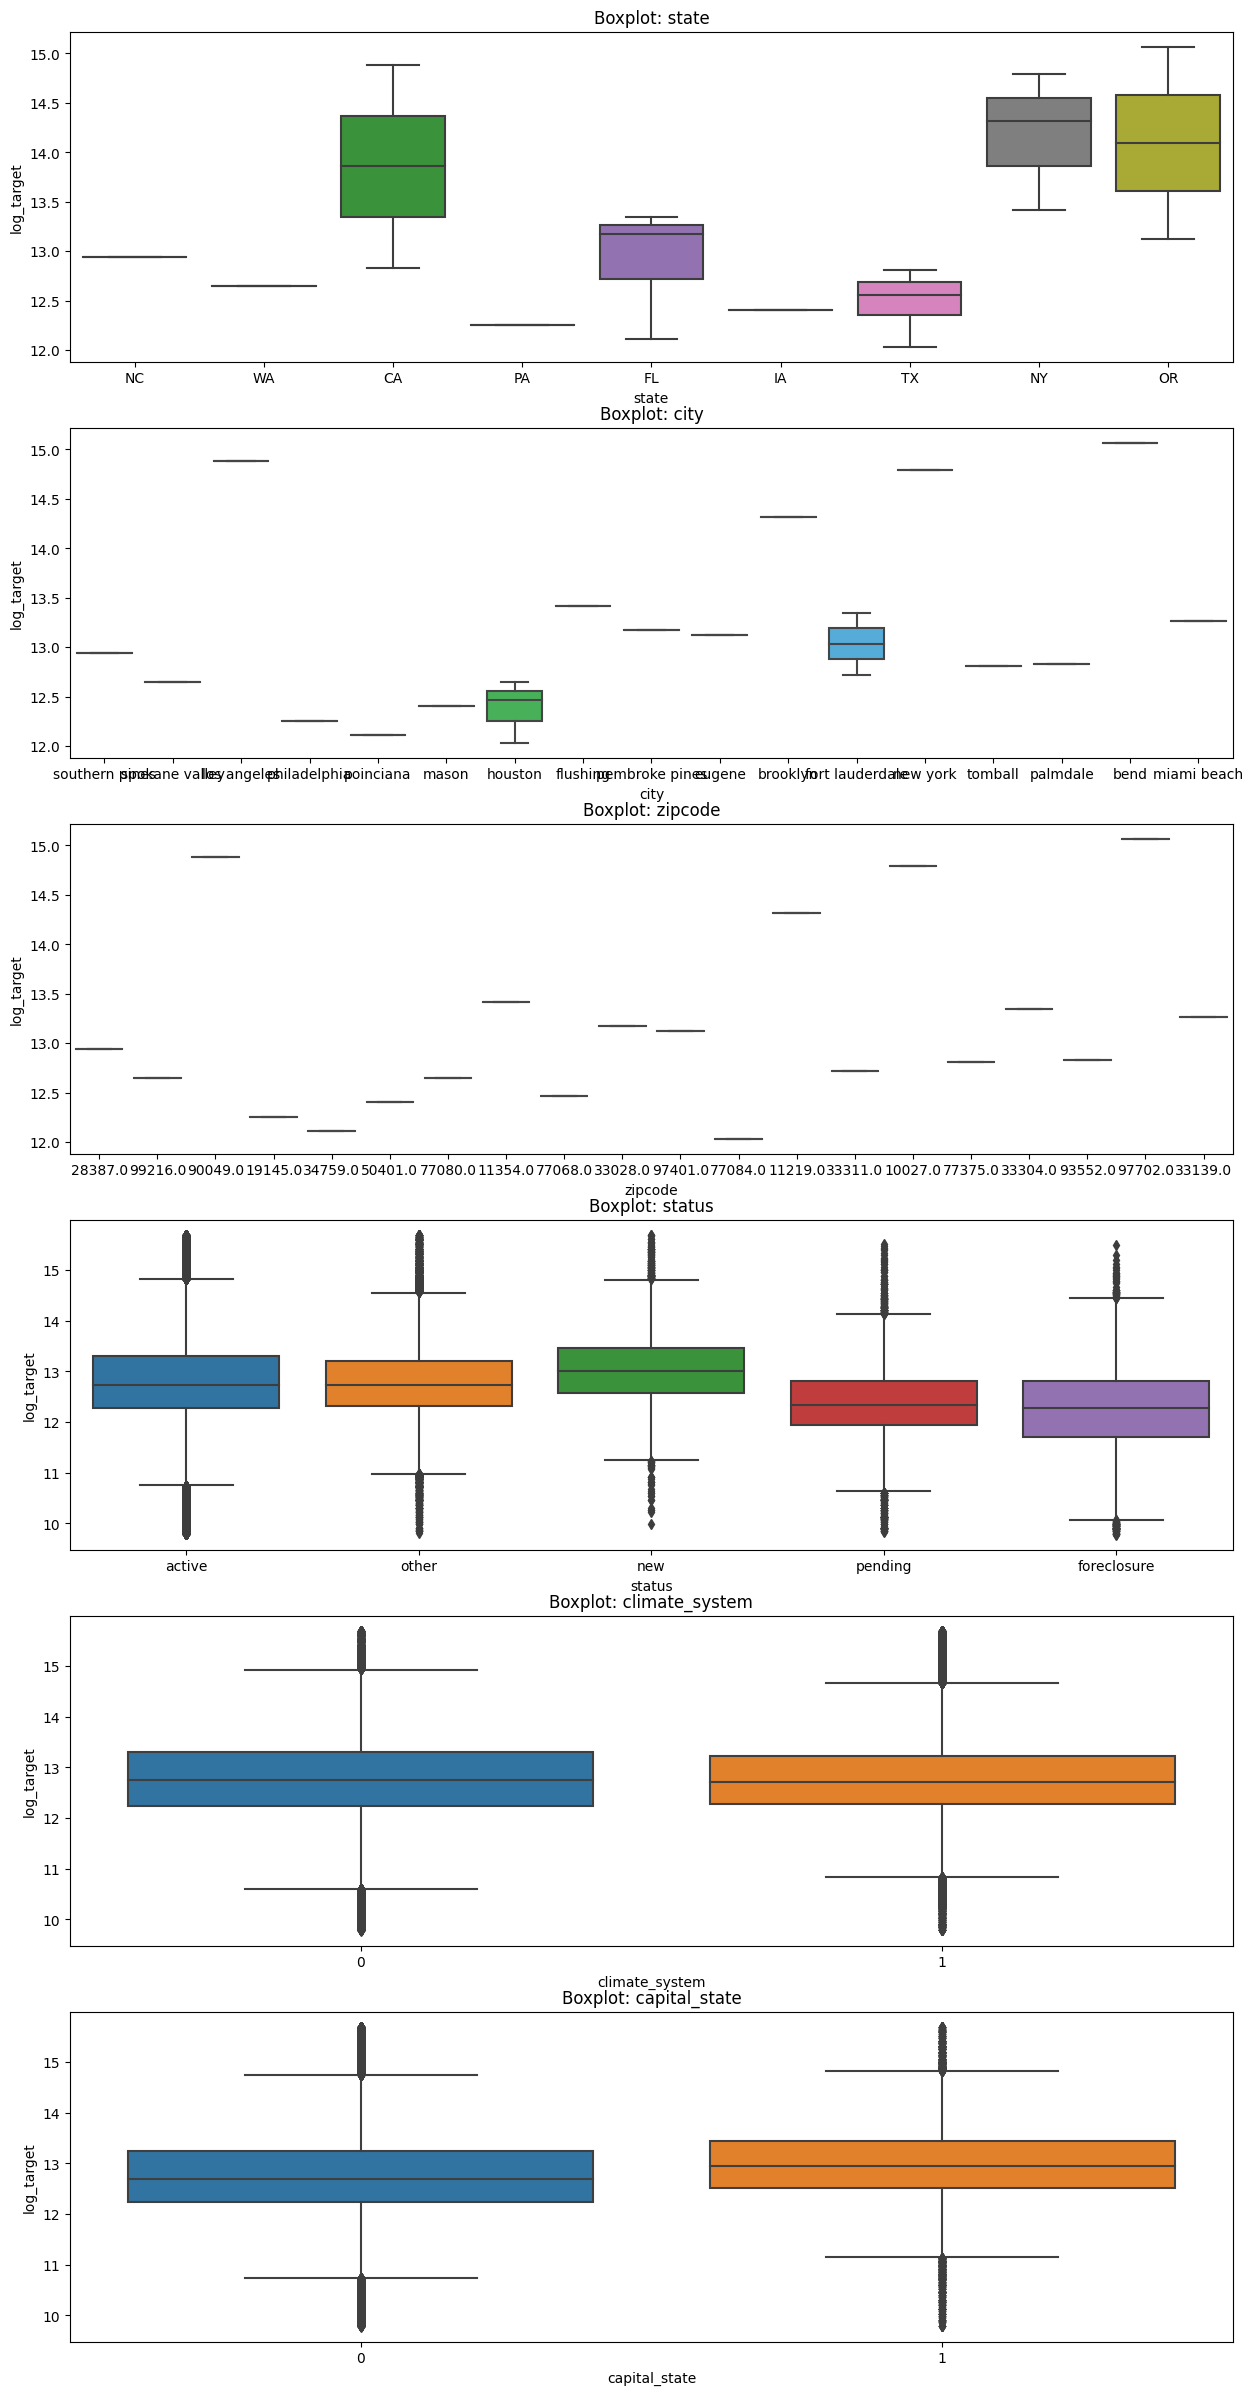

In [67]:
#построим диаграммы ящик с усами для каждого признака
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 30))
#для признака state
box_climate = sns.boxplot(x=r7['state'][:20],y=r7['log_target'],ax=axes[0])
box_climate.set_title('Boxplot: state')
#для признака city
box_climate = sns.boxplot(x=r7['city'][:20],y=r7['log_target'],ax=axes[1])
box_climate.set_title('Boxplot: city')
#для признака zipcode
box_climate = sns.boxplot(x=r7['zipcode'][:20],y=r7['log_target'],ax=axes[2])
box_climate.set_title('Boxplot: zipcode')
#для признака status
box_climate = sns.boxplot(x=r7['status'],y=r7['log_target'],ax=axes[3])
box_climate.set_title('Boxplot: status')
#для признака climate_system
box_climate = sns.boxplot(x=r7['climate_system'],y=r7['log_target'],ax=axes[4])
box_climate.set_title('Boxplot: climate_system')
#для признака capital_state
box_climate = sns.boxplot(x=r7['capital_state'],y=r7['log_target'],ax=axes[5])
box_climate.set_title('Boxplot: capital_state')

По диаграммам сложно оценить зависимости, оценим наличие статистической зависимости между признаком target и категориальными признаками с помощью Теста Крускала-Уоллиса, так как target - это непрерывный, не распределен нормально.

Сначала закодируем признаки.

In [68]:
r8=r7.copy()

In [69]:
#закодируем категориальные признаки
# Создаем список признаков для одиночного кодирования
one_feature = ['status', 'type']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=one_feature, use_cat_names=True)
encoded_data = encoder.fit_transform(r8[one_feature])
# Присоединяем к датафрейму закодированные признаки
r8 = pd.concat([r8, encoded_data], axis=1)

#Создаем список признаков для двоичного кодирования
binar_feature=['state','city','zipcode']
# Создаем объект двоичного кодирования и выполняем кодирование
encoder_bi = ce.BinaryEncoder(cols=binar_feature)
encoded_data_bi = encoder_bi.fit_transform(r7[binar_feature])
# Присоединяем к датафрейму закодированные признаки
r8 = pd.concat([r8, encoded_data_bi], axis=1)

In [70]:
#формируем список закодированных признаков
encoder_lst=list(encoded_data)+list(encoded_data_bi)+bin_feature

In [71]:
#проведем Тест Крускала-Уоллиса
# выдвигаем гипотезы
H0 = 'Медиана одинакова для всех групп'
Ha = 'Медиана не одинакова для всех групп (мы отвергаем H0)'
alpha = 0.05 #задаем коэффициент значимости

for en_feature in encoder_lst:
    p = kruskal(r8[en_feature], r8.log_target)[1]
    s = kruskal(r8[en_feature], r8.log_target)[0]
    if p > alpha:
        print(f'Для признака {en_feature} {H0}, statistic {s}')
    else:
        print(f'Для признака {en_feature} {Ha}, statistic {s}')

Для признака status_active Медиана не одинакова для всех групп (мы отвергаем H0), statistic 518817.7326761154
Для признака status_other Медиана не одинакова для всех групп (мы отвергаем H0), statistic 528565.1320222735
Для признака status_new Медиана не одинакова для всех групп (мы отвергаем H0), statistic 549107.2779236851
Для признака status_pending Медиана не одинакова для всех групп (мы отвергаем H0), statistic 549249.3157582864
Для признака status_foreclosure Медиана не одинакова для всех групп (мы отвергаем H0), statistic 546659.3173007815
Для признака type_single_1 Медиана не одинакова для всех групп (мы отвергаем H0), statistic 500077.1879806122
Для признака type_single_2 Медиана не одинакова для всех групп (мы отвергаем H0), statistic 518726.78815403156
Для признака type_townhouse Медиана не одинакова для всех групп (мы отвергаем H0), statistic 536102.9554960828
Для признака type_other Медиана не одинакова для всех групп (мы отвергаем H0), statistic 550521.6934371493
Для призн

Для выявления зависимостей построим матрицу корреляций Спирмена.

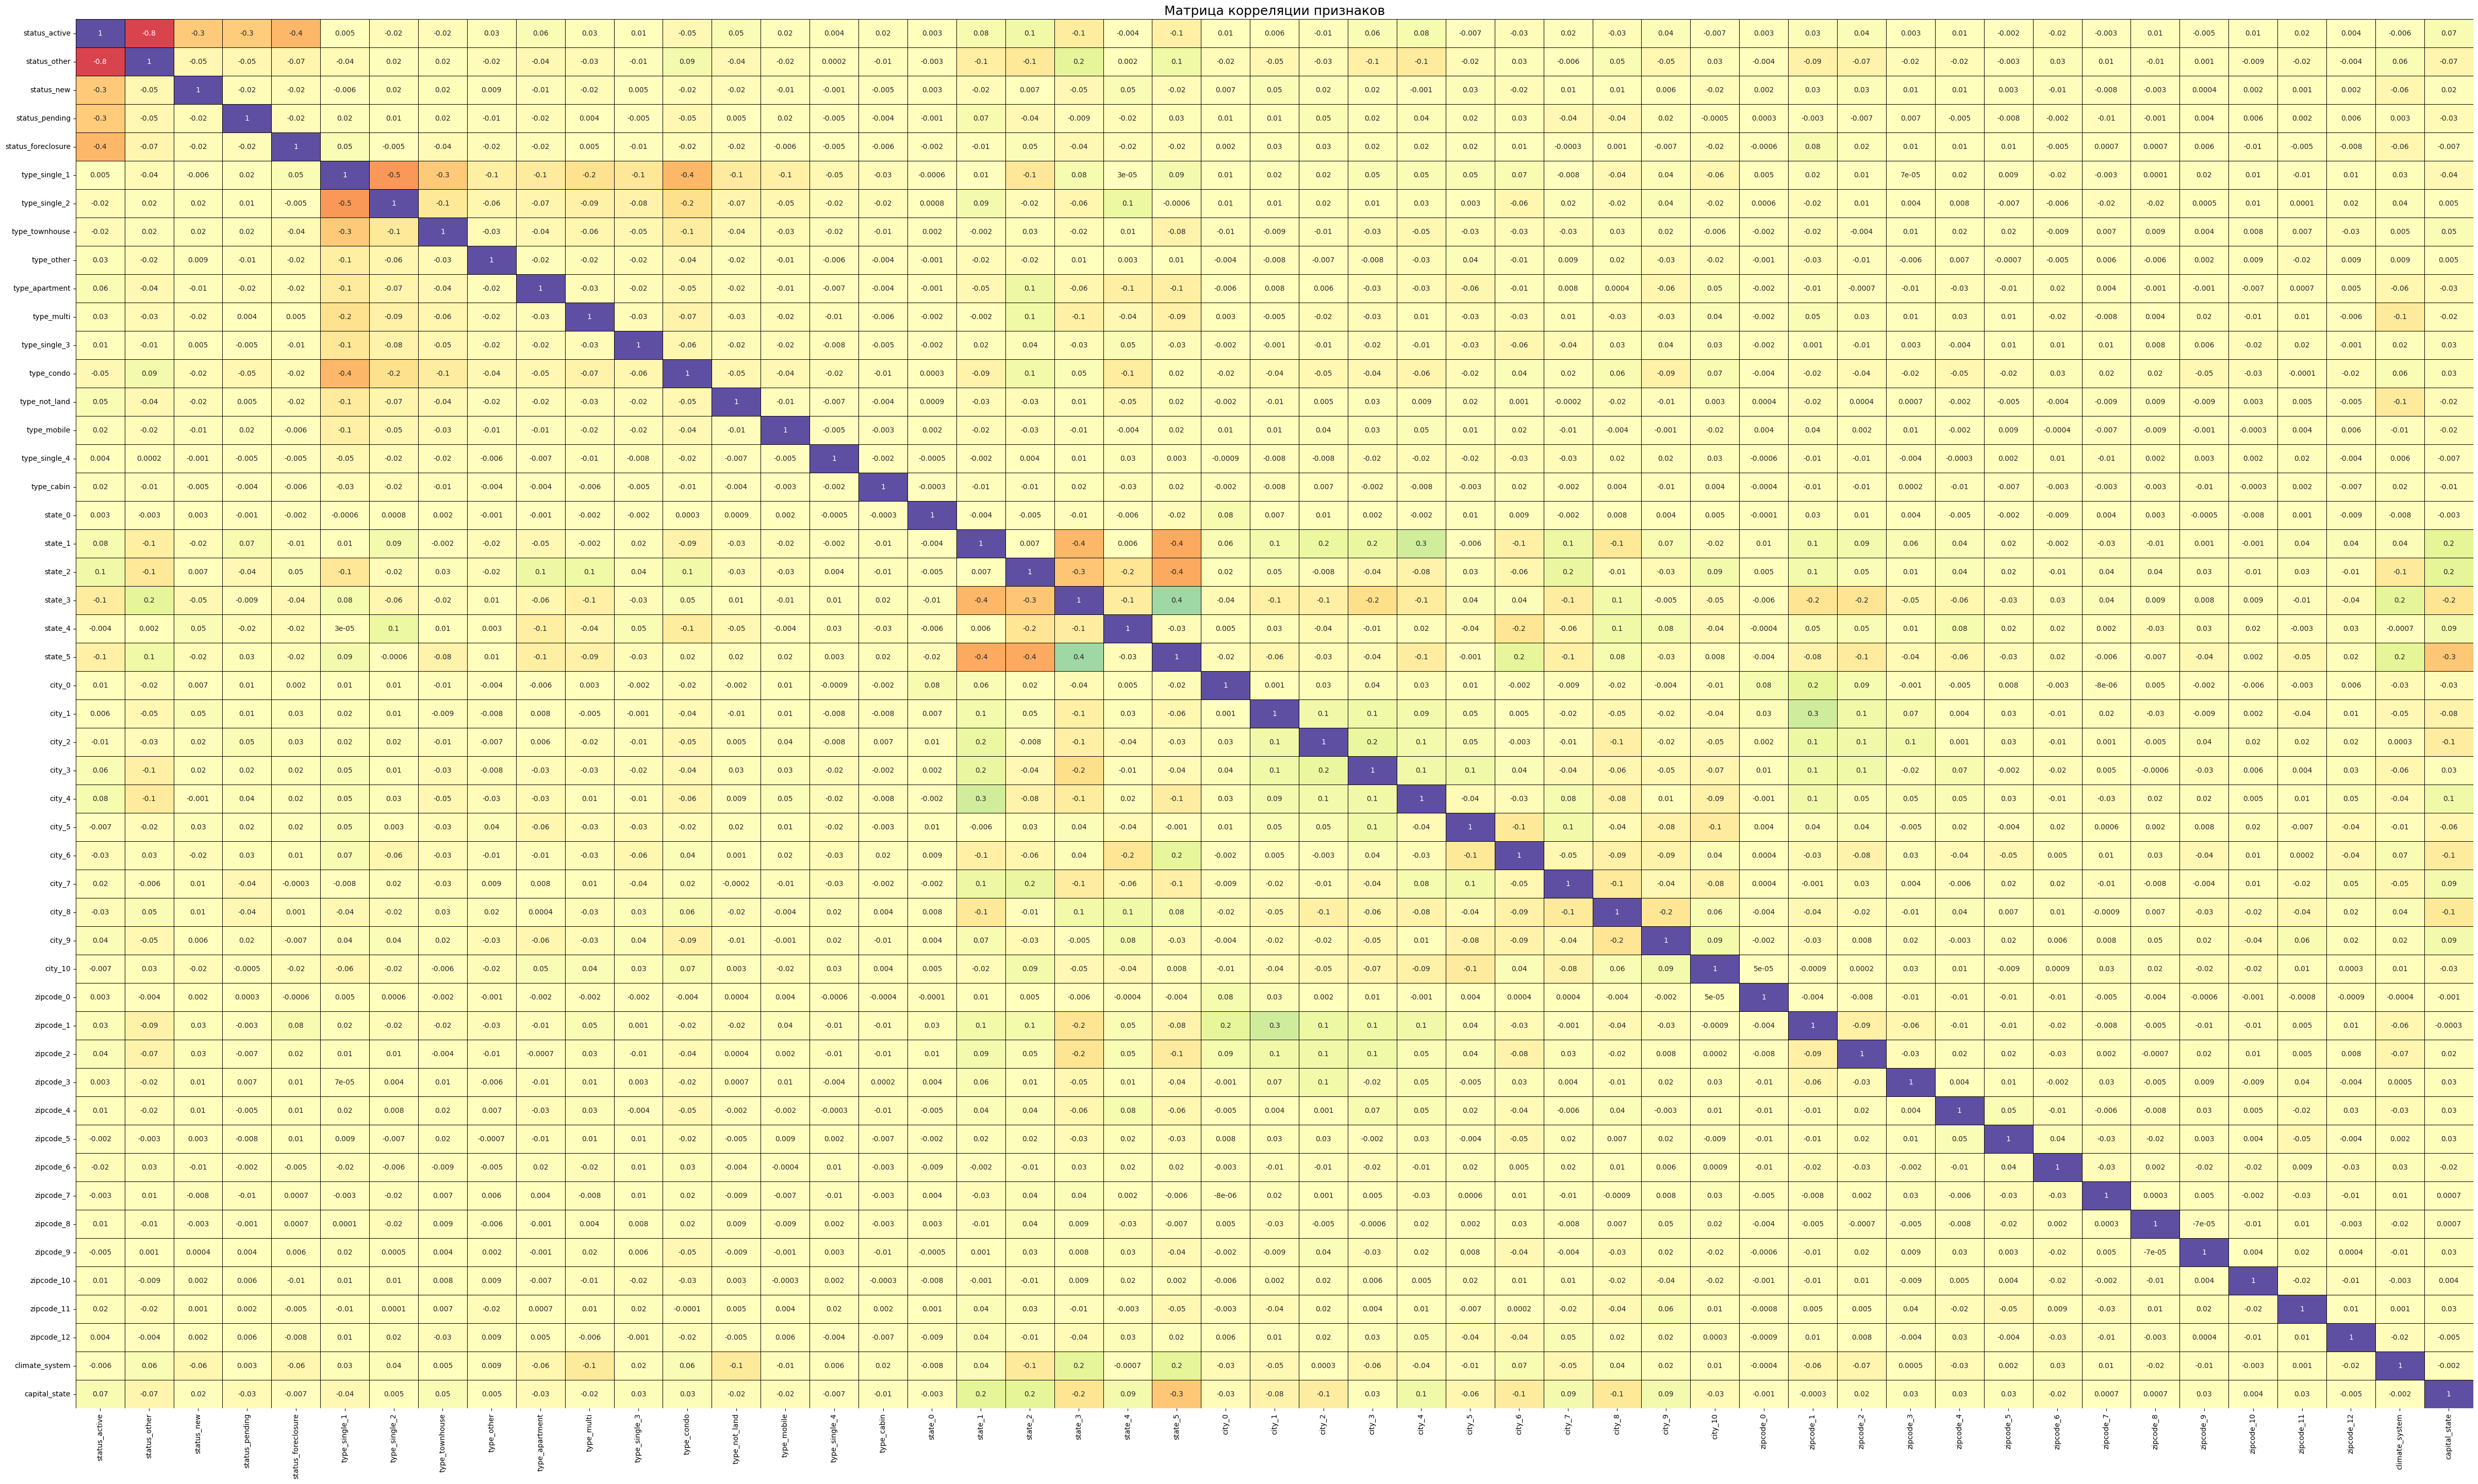

In [72]:
# построим матрицу корреляции для категориальных признаков
fig = plt.figure(figsize=(60, 35))
heatmap = sns.heatmap(
    data = r8[encoder_lst].corr(method='spearman'),
    annot = True,
    fmt = '.1g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    linewidths=0.5, 
    linecolor='black',
    cbar=False
);
heatmap.set_title('Матрица корреляции признаков', fontsize=18);

Анализ матрицы корреляции позволил выяснить, что имеет место быть мультиколлинеарность между признаками stat_active и stat_other - коэффициент корреляции равен -0.8. Возможно это связано с тем, что признак stat_other содержит много представителей stat_active. Существует средняя связь между (коэффициент корреляции равен -0.5) type_single_2 и type_single_1. Встречаются слабые корреляционные связи равные 0.3, 0.4.

In [78]:
r9=r8.copy()

In [79]:
#для дальнейшего анализа удалим из таблицы столбцы с незакодированными категориальными признаками
r9.drop(cat_feature, axis=1, inplace=True)

Отберем лучшие признаки с помощью SelectKBest. Но сначала разделим выборку на обучающую и валидационную.

In [80]:
#сформируем матрицу наблюдений X
X = r9.drop(['target', 'log_target'], axis=1)
# вектор целевой переменной y 
y = r9['target']
# и его логарифм y_log
y_log = r9['log_target']

В качестве типа валидации выберем - hold-out-валидацию. Так как у нас достаточно много данных.

In [81]:
#разобьем выборку на обучающую и валидационную в соотношении 80/20
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(X, y_log, test_size=0.20, random_state=42)

In [82]:
#c помощью SelectKBest отберем 25 признаков, 
# наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе
# создаем объект типа Select
selector = SelectKBest(f_regression, k=25)
# применим selector к нашим данным
selector.fit(X_train, y_train_log)
# выведем названия отобранных признаков
selector.get_feature_names_out()

array(['baths', 'sqft', 'beds', 'sch_rating', 'property_age',
       'capital_state', 'status_new', 'status_pending',
       'status_foreclosure', 'type_single_1', 'type_single_2',
       'type_apartment', 'type_multi', 'type_single_3', 'type_condo',
       'type_not_land', 'type_mobile', 'state_1', 'state_2', 'state_3',
       'state_4', 'state_5', 'city_4', 'city_5', 'city_10'], dtype=object)

Среди признаков отобранных SelectKBest есть признаки между, которыми была выявлена мультиколлинеарность: beds и sqft (коэффициент корреляции 0.7). 

Из числовых признаков beds и sqft оставим sqft, он больше коррелирует с целевым признаком. 

На этот закончим этап разведывательного анализа. На этом этапе нам удалось:

* избавиться от выбросов,
* заполнить пропуски,
* оценить зависимости,
* отобрать переменные для построения прогноза.

In [85]:
#сохраним отобранные признаки, целевой и целевой логарифмированный в отдельную таблицу
r10=r9[['baths', 'sqft', 'sch_rating', 'property_age',
       'capital_state', 'status_new', 'status_pending',
       'status_foreclosure', 'type_single_1', 'type_single_2',
       'type_apartment', 'type_multi', 'type_single_3', 'type_condo',
       'type_not_land', 'type_mobile', 'state_1', 'state_2', 'state_3',
       'state_4', 'state_5', 'city_4', 'city_5', 'city_10','target','log_target']].copy()

In [86]:
#выгрузим таблицу с данными для дальнейшей обработки в другом ноутбуке
r10.to_csv('eda_data.csv',index=False)